## Ноутбук по астрономии



In [ ]:
#для начала работы установи эти пакеты
#!pip install astropy
#!pip install photutils
#!pip install astroml
#!pip install latex
#!pip install lightkurve
#!pip install TESS_PRF
#!pip install tess-point
#!pip install git+https://github.com/CheerfulUser/TESSreduce.git
#!pip install astroquery
#!pip install Galsim

In [ ]:
#установки ноутбук с файлами для работы и создай на верхнем уровне папку "astronomy python"!
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/astronomy python/

Mounted at /content/drive


Классификация переменных звезд - https://github.com/Amirosein/Variable-Stars-Classification

## **Раздел 1. Звезды**

# 1. Найдем звезды на изображении при помощи чистой математики!

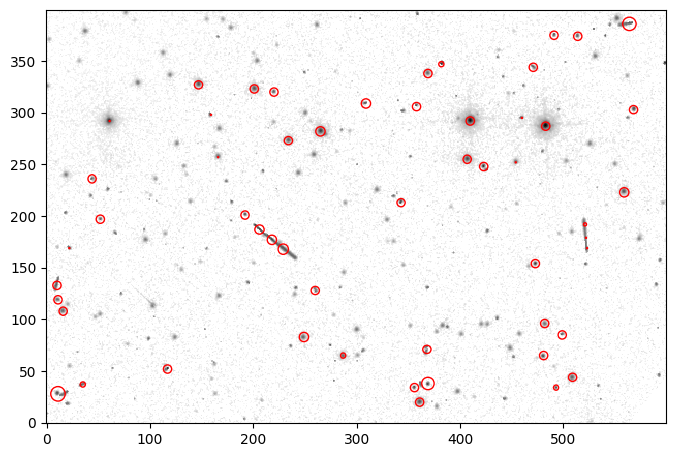

In [ ]:
from astropy.io import fits
import numpy as np
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Чтение данных из файла fits
fits_file = fits.open('/content/drive/MyDrive/astronomy python/ngc1261.fits')
image_data = fits_file[0].data

# Выбор участка большого изображения
section1 = image_data[2250:2650, 5150:5750]

# Применение гауссова фильтра для сглаживания изображения
smoothed_data = gaussian_filter(section1, sigma=2)

# Нахождение пиков на изображении
peaks = peak_local_max(smoothed_data, min_distance=5, threshold_abs=100)

# Определение полуширины для каждой звезды
def find_fwhm(data, peak):
    y, x = peak
    intensity_profile = data[y, :]
    smoothed_profile = gaussian_filter1d(intensity_profile, sigma=2)
    half_max_intensity = smoothed_profile.max() / 2
    left_idx = np.where(smoothed_profile[:x] <= half_max_intensity)[0][-1]
    right_idx = np.where(smoothed_profile[x:] <= half_max_intensity)[0][0] + x
    return right_idx - left_idx

fwhms = [find_fwhm(smoothed_data, peak) for peak in peaks]

# Увеличение яркости изображения
brightened_data = section1 * 1.5  # Увеличиваем яркость на 50%

# Создание нового изображения с обведенными звездами, инвертированными цветами и увеличенной яркостью
plt.figure(figsize=(8, 8))
plt.imshow(brightened_data, cmap='gray_r')

for peak, fwhm in zip(peaks, fwhms):
    circle = Circle((peak[1], peak[0]), fwhm/2, color='r', fill=False)
    plt.gca().add_patch(circle)

plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin = 'lower', interpolation='nearest')


# 2. Сделаем то же самое, но с более классной библиотекой!

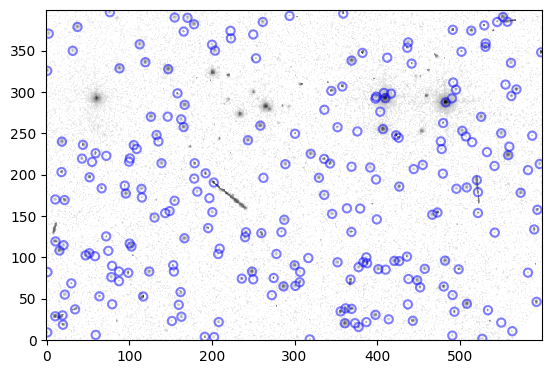

In [ ]:
from astropy.io import fits
fits_file = fits.open('/content/drive/MyDrive/astronomy python/ngc1261.fits')
image_data = fits_file[0].data
# выбираем регион огромного изображения, с которым будем работать
section1 = image_data[2250:2650, 5150:5750]
#находим mean (среднее), median (медианное), and среднеквадратичное отклонение
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(section1,sigma=3.0)
# ставим модуль для поиска звезд
from photutils.detection import DAOStarFinder
#найдем звезды, которые имеют полную FWHM около 3 пикселей и
#находятся как минимум на 5 сигм (σ) выше уровня фона.
daofind = DAOStarFinder(fwhm = 3.0, threshold = 5.0*std)
# display data with matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture
mask = np.zeros(section1.shape, dtype=bool)
# select regions to mask (y:y,x:x)
mask[260:320,40:80] = True
mask[230:350,170:240] = True
mask[260:340,240:320] = True
mask[250:330,420:470] = True
# define sources table
sources = daofind(section1-median,mask=mask)
xpix = sources['xcentroid']
ypix = sources['ycentroid']
# plot new table
positions = np.transpose((xpix,ypix))
apertures = CircularAperture(positions,r=5.0)
plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin = 'lower', interpolation='nearest')
apertures.plot(color='blue',lw=1.5, alpha = 0.5);

# 3. Построим тензорное представление!

Оценка FWHM: 6.333333333333333


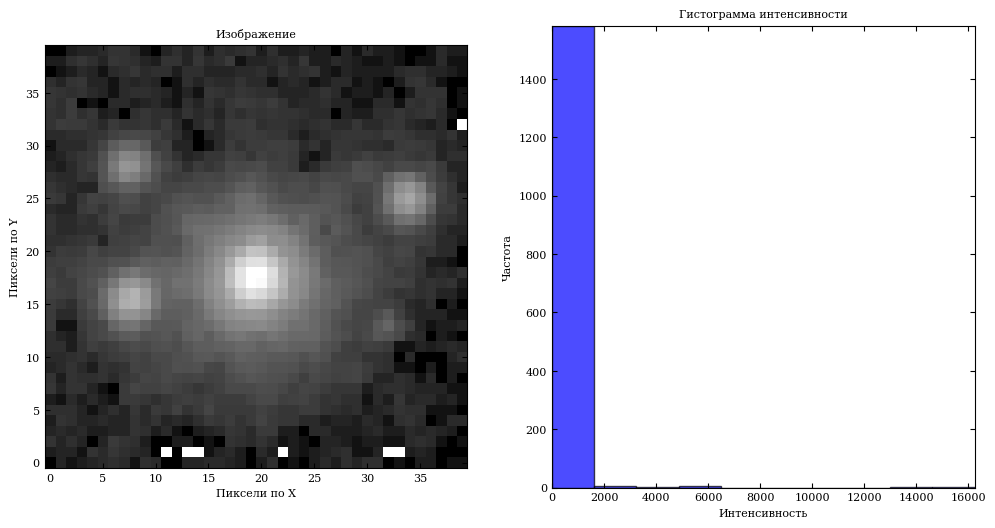

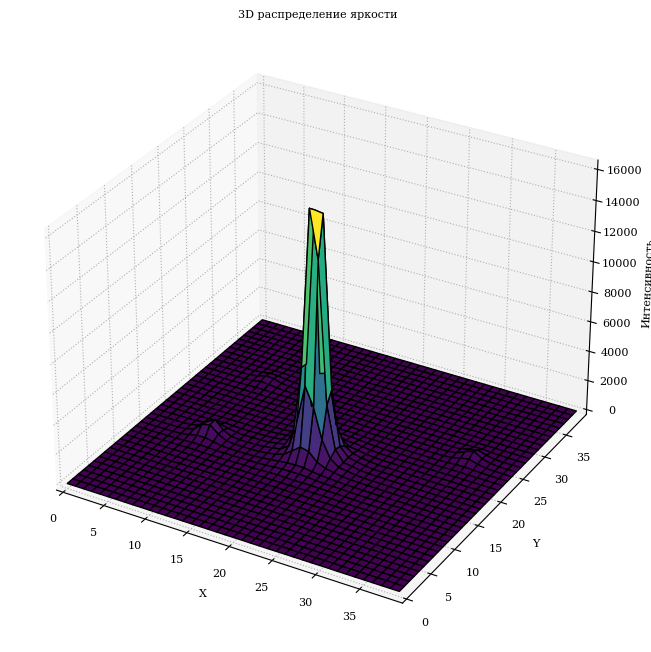

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from skimage.feature import peak_local_max
from matplotlib.colors import LogNorm

# Открытие файла fits
fits_file = fits.open('/content/drive/MyDrive/astronomy python/sample_star.fit')
image_data = fits_file[0].data

# Определение функции для нахождения FWHM
def find_fwhm(data):
    smoothed_data = gaussian_filter(data, sigma=2)
    peaks = peak_local_max(smoothed_data, min_distance=5, threshold_abs=100)
    fwhms = [calculate_fwhm(smoothed_data, peak) for peak in peaks]
    return np.mean(fwhms)

# Расчет FWHM
def calculate_fwhm(data, peak):
    y, x = peak
    intensity_profile = data[y, :]
    smoothed_profile = gaussian_filter1d(intensity_profile, sigma=2)
    half_max_intensity = smoothed_profile.max() / 2
    left_idx = np.where(smoothed_profile[:x] <= half_max_intensity)[0][-1]
    right_idx = np.where(smoothed_profile[x:] <= half_max_intensity)[0][0] + x
    return right_idx - left_idx

# Оценка FWHM
fwhm = find_fwhm(image_data)
print("Оценка FWHM:", fwhm)

# Построение графика изображения и гистограммы
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image_data, cmap='gray', origin='lower', norm=LogNorm())
ax1.set_title('Изображение')
ax1.set_xlabel('Пиксели по X')
ax1.set_ylabel('Пиксели по Y')

ax2.hist(image_data.flatten(), bins=100, color='blue', alpha=0.7)
ax2.set_title('Гистограмма интенсивности')
ax2.set_xlabel('Интенсивность')
ax2.set_ylabel('Частота')

plt.show()

# Создание трехмерного представления распределения яркости
x = np.arange(image_data.shape[1])
y = np.arange(image_data.shape[0])
X, Y = np.meshgrid(x, y)
Z = image_data

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Интенсивность')
ax.set_title('3D распределение яркости')
plt.show()


# 4. Построим график FWHM и распределение Гаусса!

Оценка FWHM для самой яркой звезды: 9


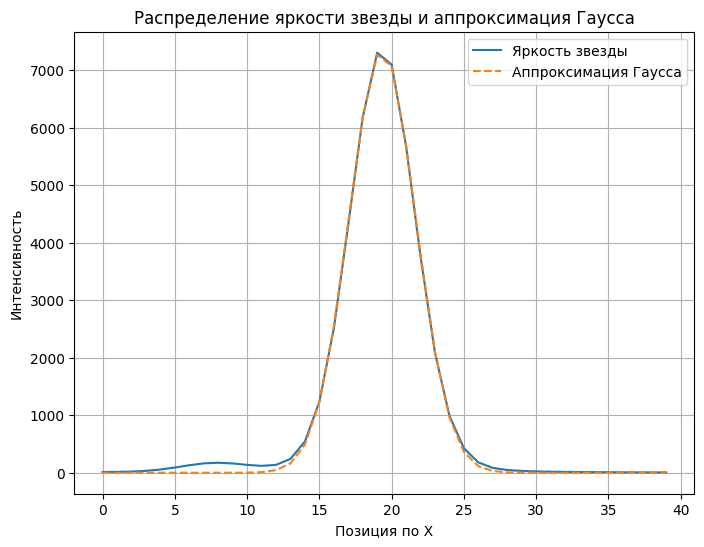

In [ ]:
from astropy.io import fits
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from skimage.feature import peak_local_max
from scipy.optimize import curve_fit

# Открытие файла fits
fits_file = fits.open('/content/drive/MyDrive/astronomy python/sample_star.fit')
image_data = fits_file[0].data

# Нахождение пика с максимальной интенсивностью
max_peak = np.unravel_index(np.argmax(image_data, axis=None), image_data.shape)

# Определение полуширины для самой яркой звезды
def find_fwhm(data, peak):
    smoothed_data = gaussian_filter(data, sigma=2)
    fwhm = calculate_fwhm(smoothed_data, peak)
    return fwhm

# Расчет полуширины
def calculate_fwhm(data, peak):
    y, x = peak
    intensity_profile = data[y, :]
    smoothed_profile = gaussian_filter1d(intensity_profile, sigma=2)
    half_max_intensity = smoothed_profile.max() / 2
    left_idx = np.where(smoothed_profile[:x] <= half_max_intensity)[0][-1]
    right_idx = np.where(smoothed_profile[x:] <= half_max_intensity)[0][0] + x
    return right_idx - left_idx

# Оценка FWHM для самой яркой звезды
fwhm = find_fwhm(image_data, max_peak)
print("Оценка FWHM для самой яркой звезды:", fwhm)

# Выделение яркости звезды в виде одномерного массива данных
y_peak, x_peak = max_peak
intensity_profile = image_data[y_peak, :]
smoothed_profile = gaussian_filter1d(intensity_profile, sigma=2)

# Определение координат для построения графика
x_values = np.arange(len(smoothed_profile))

# Определение функции Гаусса
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Подгонка данных под функцию Гаусса
popt, _ = curve_fit(gaussian, x_values, smoothed_profile, p0=[1, x_peak, fwhm/2])

# Построение графика яркости и аппроксимации Гаусса
plt.figure(figsize=(8, 6))
plt.plot(x_values, smoothed_profile, label='Яркость звезды')
plt.plot(x_values, gaussian(x_values, *popt), label='Аппроксимация Гаусса', linestyle='--')
plt.xlabel('Позиция по X')
plt.ylabel('Интенсивность')
plt.title('Распределение яркости звезды и аппроксимация Гаусса')
plt.legend()
plt.grid(True)
plt.show()


## Рассмотрим SNR для каждой звезды!

<ipython-input-3-5f6202fdd978>:28: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(selected_region, cmap='gray')
<ipython-input-3-5f6202fdd978>:28: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(selected_region, cmap='gray')


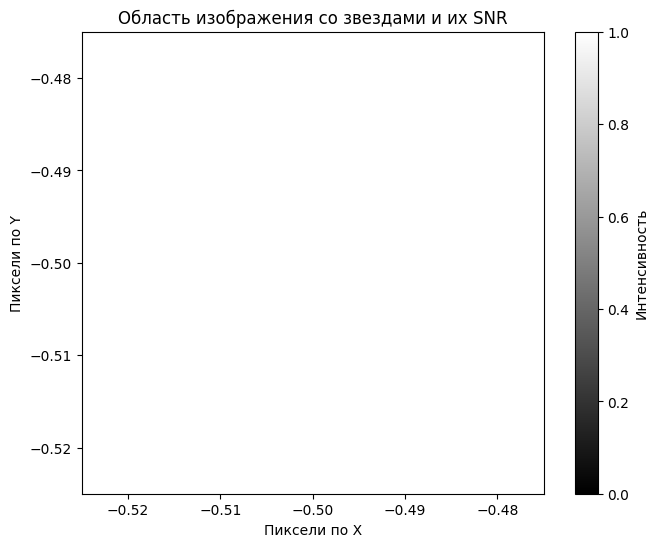

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from skimage.feature import peak_local_max

# Открытие файла fits
fits_file = fits.open('/content/drive/MyDrive/astronomy python/sample_star.fit')
image_data = fits_file[0].data

# Выбор области на изображении
selected_region = image_data[2250:2650, 5150:5750]

# Нахождение пиков (звезд) в выбранной области
peaks = peak_local_max(selected_region, min_distance=5, threshold_abs=100)

# Определение сигнал-шум для каждой звезды
def calculate_signal_noise_ratio(data, peak):
    y, x = peak
    intensity = data[y, x]
    background = np.mean(data[y-5:y+5, x-5:x+5])
    noise = np.std(data[y-5:y+5, x-5:x+5])
    snr = (intensity - background) / noise
    return snr

# Создание изображения с обозначенными звездами и подписанными значениями SNR
plt.figure(figsize=(8, 6))
plt.imshow(selected_region, cmap='gray')
plt.colorbar(label='Интенсивность')

for peak in peaks:
    y_global = peak[0] + 2250  # Преобразование координат из локальных в глобальные
    x_global = peak[1] + 5150
    snr = calculate_signal_noise_ratio(image_data, (y_global, x_global))
    plt.plot(peak[1], peak[0], 'r+', markersize=10)
    plt.text(peak[1] + 5, peak[0] + 5, f'SNR: {snr:.2f}', color='red')

plt.title('Область изображения со звездами и их SNR')
plt.xlabel('Пиксели по X')
plt.ylabel('Пиксели по Y')
plt.show()


Filename: /root/.astropy/cache/download/url/8da27de5aa6b0db633441e82715bedf3/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  NN_EMISSIVITY_I_LOBE_150.0MHZ    1 ImageHDU        23   (1024, 1452)   float64   


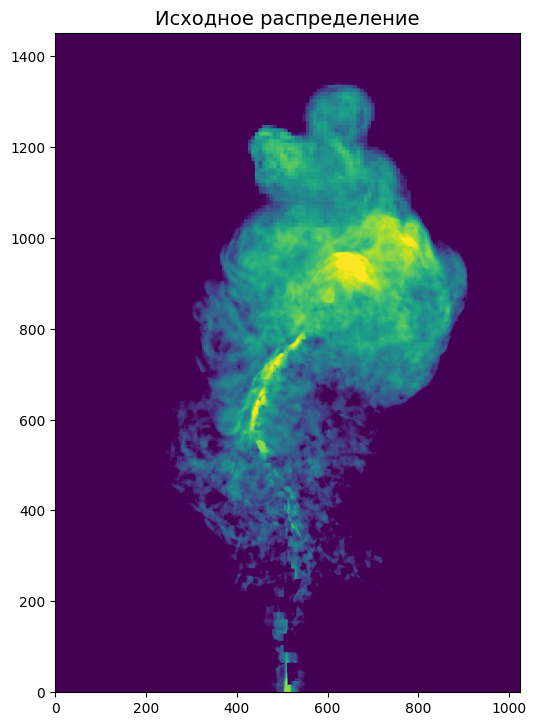

In [ ]:
from astropy.utils.data import download_file
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from astropy.convolution import Gaussian2DKernel
from astropy.modeling.models import Lorentz1D
from astropy.convolution import convolve_fft

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
file_i = download_file(
    'http://data.astropy.org/tutorials/synthetic-images/synchrotron_i_lobe_0700_150MHz_sm.fits',
    cache=True)
hdulist = fits.open(file_i)
hdulist.info()
hdu = hdulist['NN_EMISSIVITY_I_LOBE_150.0MHZ']
#hdu.header

fig = plt.figure(figsize=(6,12))
fig.add_subplot(111)

# We plot it in log-scale and add a small number to avoid nan values.
plt.title('Исходное распределение', fontsize=14)
plt.imshow(np.log10(hdu.data+1E-3), vmin=-1, vmax=1, origin='lower')





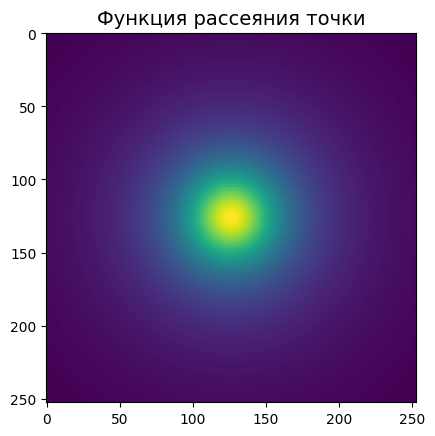

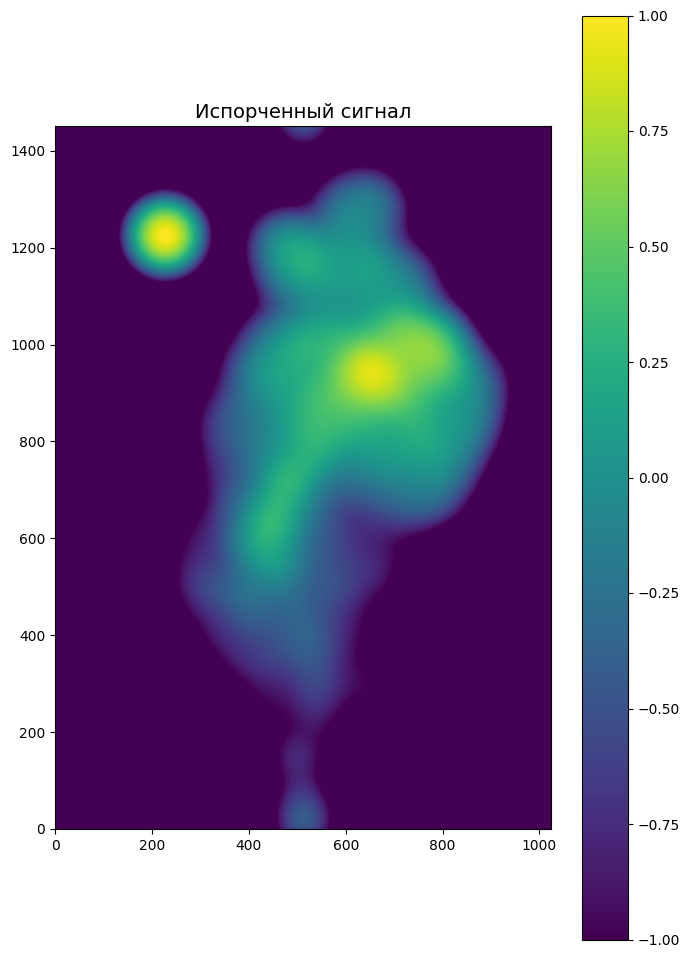

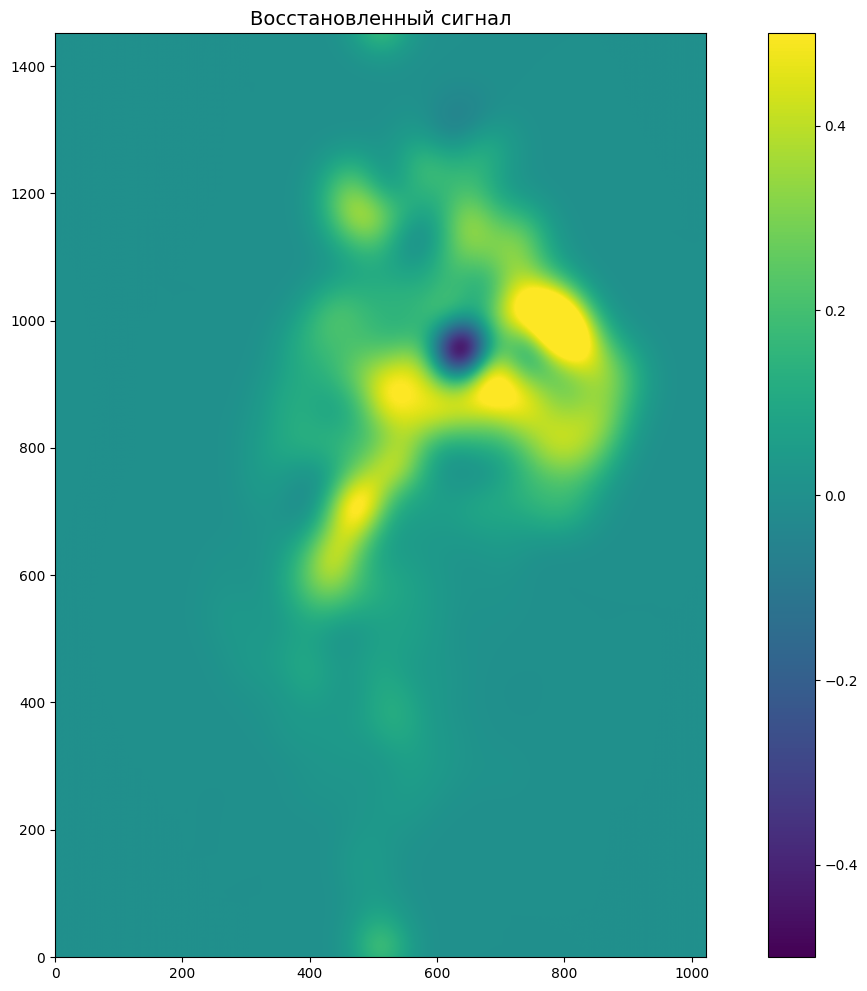

In [ ]:
dist_obj = 200*u.Mpc

# We have the RA in hh:mm:ss and DEC in dd:mm:ss format.
# We will use Skycoord to convert them into degrees later.
ra_obj = '19h59m28.3566s'
dec_obj = '+40d44m02.096s'

cdelt1 = ((hdu.header['CDELT1']*u.cm/dist_obj.to('cm'))*u.rad).to('deg')
cdelt2 = ((hdu.header['CDELT2']*u.cm/dist_obj.to('cm'))*u.rad).to('deg')

telescope_resolution = 1*u.arcsecond

# calculate the sigma in pixels.
# since cdelt is in degrees, we use _.to('deg')
sigma = telescope_resolution.to('deg')/cdelt2


psf = Gaussian2DKernel(sigma)

# let's take a look:
plt.imshow(psf.array.value)

# set FWHM and psf grid
telescope_resolution = 1*u.arcsecond
gamma = telescope_resolution.to('deg')/cdelt2
x_grid = np.outer(np.linspace(-gamma*4,gamma*4,int(8*gamma)),np.ones(int(8*gamma)))
r_grid = np.sqrt(x_grid**2 + np.transpose(x_grid**2))
lorentzian = Lorentz1D(fwhm=2*gamma)

# extrude a 2D azimuthally symmetric PSF
lorentzian_psf = lorentzian(r_grid)

# normalization
lorentzian_psf /= np.sum(lorentzian_psf)

# let's take a look again:
plt.title('Функция рассеяния точки', fontsize=14)
plt.imshow(lorentzian_psf.value, interpolation='none')

convolved_image = convolve_fft(hdu.data, psf, boundary='wrap')

# Put a psf at the corner of the image
delta_x_psf=100 # number of pixels from the edges
xmin, xmax = -psf.shape[1]-delta_x_psf, -delta_x_psf
ymin, ymax = delta_x_psf, delta_x_psf+psf.shape[0]
convolved_image[xmin:xmax, ymin:ymax] = psf.array/psf.array.max()*10


wcs = WCS(hdu.header)
fig = plt.figure(figsize=(8,12))
#i_plot = fig.add_subplot(111, projection=wcs)
plt.title('Испорченный сигнал', fontsize=14)
plt.imshow(np.log10(convolved_image+1e-3), vmin=-1, vmax=1.0, origin='lower', cmap=plt.cm.viridis)
#plt.xlabel('RA')
#plt.ylabel('Dec')
plt.colorbar()


#hdulist.info()


file_q = download_file(
    'http://data.astropy.org/tutorials/synthetic-images/synchrotron_q_lobe_0700_150MHz_sm.fits',
    cache=True)
hdulist = fits.open(file_q)
hdu_q = hdulist['NN_EMISSIVITY_Q_LOBE_150.0MHZ']


  #make a fits header
w = WCS(naxis=2)

# reference pixel coordinate
w.wcs.crpix = [hdu.data.shape[0]/2,hdu.data.shape[1]/2]

# sizes of the pixel in degrees
w.wcs.cdelt = [-cdelt1.base, cdelt2.base]

# converting ra and dec into degrees
c = SkyCoord(ra_obj, dec_obj)
w.wcs.crval = [c.ra.deg, c.dec.deg]

# the units of the axes are in degrees
w.wcs.cunit = ['deg', 'deg']

# Update the header with the wcs_header we created earlier
wcs_header = w.to_header()
hdu.header.update(wcs_header)
hdu_q.header.update(wcs_header)
#hdu_u.header.update(wcs_header)

# Convolve the images with the the psf
convolved_image_q = convolve_fft(hdu_q.data, psf, boundary='wrap')

wcs = WCS(hdu.header)
fig = plt.figure(figsize=(16,12))
#fig.add_subplot(121, projection=wcs)
plt.title('Восстановленный сигнал', fontsize=14)
plt.imshow(convolved_image_q, vmin=-0.5, vmax=0.5, origin='lower', cmap=plt.cm.viridis)
#plt.xlabel('RA')
#plt.ylabel('Dec')
plt.colorbar()


# 5. Теперь сделаем апертурную фотометрию!


Добавим параметры суммы апертуры - сумма данных об объекте в апертуре масштабированная по количеству фотонов на единицу данных и коэффициентам экспозиции и фон

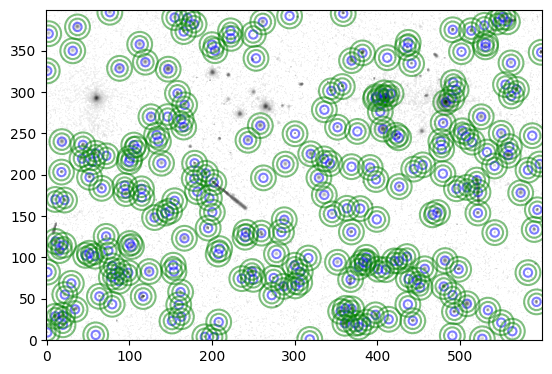

In [ ]:
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry

# define annuluses
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

# plot annuluses
plt.figure()
plt.imshow(section1, cmap='Greys', norm = LogNorm(), origin = 'lower')
apertures.plot(color='blue',lw=1.5, alpha = 0.5);
annulus_aperture.plot(color='green',lw=1.5,alpha=0.5);
plt.show()

In [ ]:
aperstats = ApertureStats(section1, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(section1)
total_bkg = bkg_mean*aperture_area

# perform aperture photometry
star_data = aperture_photometry(section1, apertures)

# add backgrounds to table
star_data['total_bkg'] = total_bkg

# format and print data
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'
star_data.pprint()

 id  xcenter    ycenter   aperture_sum total_bkg 
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1  318.46944 0.55300125    73.486366 -2.3676931
  2  527.17645  1.2792742    303.24214  59.315913
  3  191.46528  3.7020282    646.82736  17.183478
  4  202.71573  3.4014466    115.52431  203.39575
  5  490.89397  5.1303846    19.561524 -11.175626
  6    59.5149  6.0011993    5.5503375 -34.906585
  7 0.95596716  8.9967015    111.12054 -19.102524
  8  563.50303  10.471816   0.46693871  -34.18792
  9  377.50981  15.590414    1259.6102  213.69209
 10  19.926834  18.291263    2823.7584  2882.0524
...        ...        ...          ...        ...
236  178.46738  381.76826    1618.4839  167.64463
237  261.61466    384.572    1774.3376 -17.741228
238  545.18381  384.43958    1385.6104  2081.0038
239  557.51001  384.79528    10484.918  312.75677
240  155.01447  389.89157    670.36813  137.50906
241  170.54574  389.54389    841.24221  416.31074


# Сделаем анализ SNR звезд!

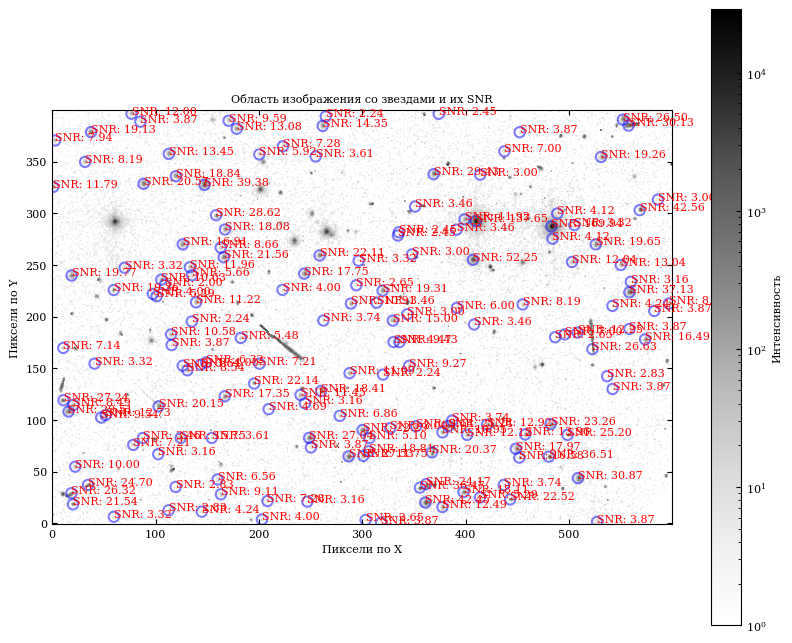

In [ ]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Открытие файла fits
fits_file = fits.open('/content/drive/MyDrive/astronomy python/ngc1261.fits')
image_data = fits_file[0].data

# Выбор региона изображения
section1 = image_data[2250:2650, 5150:5750]

# Расчет среднего, медианы и стандартного отклонения
mean, median, std = sigma_clipped_stats(section1, sigma=3.0)

# Поиск звезд с помощью DAOStarFinder
daofind = DAOStarFinder(fwhm=5.0, threshold=5.0*std)
sources = daofind(section1 - median)

# Определение функции для расчета SNR
def calculate_snr(data, source, background):
    intensity = source['peak'] - background
    noise = np.sqrt(source['peak'] + background)
    snr = intensity / noise
    return snr

# Создание маски для областей, которые нужно исключить из анализа
mask = np.zeros(section1.shape, dtype=bool)
mask[260:320, 40:80] = True
mask[230:350, 170:240] = True
mask[260:340, 240:320] = True
mask[250:330, 420:470] = True

# Расчет SNR для каждой звезды и построение графика
xpix = sources['xcentroid']
ypix = sources['ycentroid']
snrs = []

plt.figure(figsize=(10, 8))
plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')

for i in range(len(sources)):
    source = sources[i]
    x, y = xpix[i], ypix[i]
    if not mask[int(y), int(x)]:
        apertures = CircularAperture((x, y), r=5.0)
        apertures.plot(color='blue', lw=1.5, alpha=0.5)
        snr = calculate_snr(section1, source, median)
        snrs.append(snr)
        plt.text(x, y, f'SNR: {snr:.2f}', color='red')

plt.colorbar(label='Интенсивность')
plt.title('Область изображения со звездами и их SNR')
plt.xlabel('Пиксели по X')
plt.ylabel('Пиксели по Y')
plt.show()


## **Раздел 2. Деконволюция**

In [ ]:
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
!pip install astroml

@pickle_results: using precomputed results from 'XD_toy.pkl'


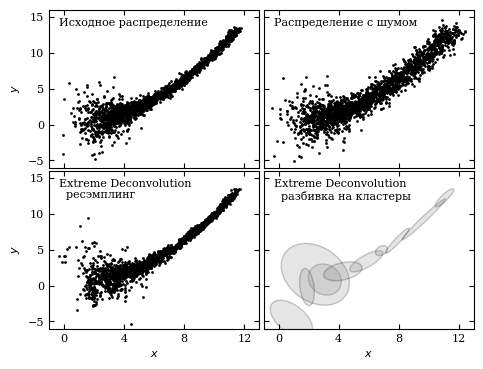

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

from astroML.utils.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Sample the dataset
N = 2000
np.random.seed(0)

# нагенерим случайных данных
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# добавим разброса для более "правильного" распределения
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# добавим шума для "наблюдаемого" распределения
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# соединим результаты для подсчета
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T


#посчитаем и сохраним результаты - обратите внимание на конструкцию с декоратором в коде
@pickle_results("XD_toy.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    clf = XDGMM(n_components, max_iter=max_iter)
    clf.fit(X, Xerr)
    return clf


clf = compute_XD_results(10, 500)
sample = clf.sample(N)

#диаграмма
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=4, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["Исходное распределение", "Распределение с шумом",
          "Extreme Deconvolution\n  ресэмплинг",
          "Extreme Deconvolution\n  разбивка на кластеры"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$')
#plt.title('Принцип работы экстремальной деконволюции', fontsize=14)
plt.show()

## сделаем деконволюцию галактики!

In [ ]:
!galsim_download_cosmos -s 23.5
# https://zenodo.org/record/3242143/files/COSMOS_23.5_training_sample.tar.gz - прямая ссылка

Text(0.5, 1.0, 'Галактика')

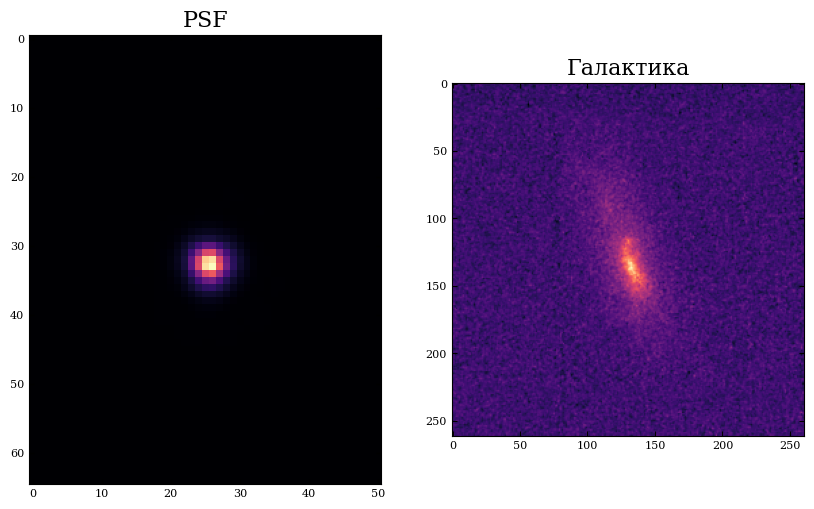

In [ ]:
import sys
sys.path.append('../')
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.fft import fft2, ifft2, fftshift, ifftshift
import galsim

%matplotlib inline

fov_pixels = 48                     # Number of pixels in FOV, the size of the image is (fov_pixels, fov_pixels).
pixel_scale = 0.2                   # Pixel scale (aresec), determines the resolution (0.2 for LSST).
upsample = 4                        # Upsample factor for the images.

exp_time = 30.                      # Exposure time (2*15 seconds).
sky_brightness = 20.48              # Sky brightness (absolute magnitude) in i band.
zero_point = 27.85                  # Instrumental zero point, i.e. asolute magnitude that would produce one e- per second.
gain = 2.3                          # CCD Gain (e-/ADU).
qe = 0.94                           # CCD Quantum efficiency.
read_noise = 8.8                    # Standrad deviation of Gaussain read noise (e-/pixel).


#COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample' # path to your COSMOS data.
# real_galaxy_catalog = galsim.RealGalaxyCatalog(sample="23.5")
real_galaxy_catalog = galsim.RealGalaxyCatalog(file_name=os.path.join( '/content/drive/MyDrive/astronomy python/real_galaxy_catalog_23.5.fits'))

# Pick a galaxy
gal_idx = 245 # Galaxy index in the catalog
gal_ori = galsim.RealGalaxy(real_galaxy_catalog, index=gal_idx)
psf_hst = real_galaxy_catalog.getPSF(gal_idx)
gal_ori_image = real_galaxy_catalog.getGalImage(gal_idx)
psf_ori_image = real_galaxy_catalog.getPSFImage(gal_idx)

cmap = 'magma' # Color map for pyplot visualization

# Visulaize galaxy & PSF in COSMOS data
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(psf_ori_image.array, cmap=cmap)
plt.title('PSF', fontsize=16)
plt.subplot(1,2,2)
plt.imshow(gal_ori_image.array, cmap=cmap)
plt.title('Галактика', fontsize=16)




Text(0.5, 1.0, 'Распределение FWHM от атмосферной PSF')

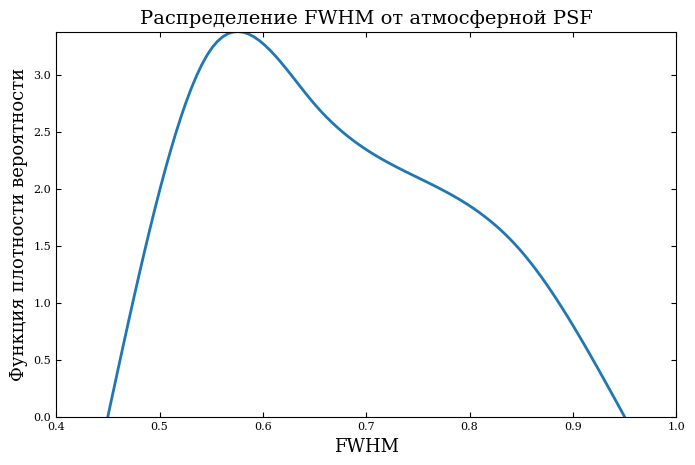

In [ ]:
random_seed = 31415
rng_base = galsim.BaseDeviate(seed=random_seed)
rng = galsim.UniformDeviate(seed=random_seed) # U(0,1).
rng_defocus = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.36) # N(0,0.36).
rng_gaussian = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.07) # N(0,0.07).

#The distribution of the atmospheric seeing, namely the FWHM of the atmospheric PSF, is a approximated distribution used in GREAT3 simulations.

# The FWHM of the PSF, namely the atmospheric seeing.
fwhms = np.array([0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
freqs = np.array([0., 20., 17., 13., 9., 0.])
fwhm_table = galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline')
fwhms = np.linspace(fwhms[0],fwhms[-1],100) # Upsample the distribution.
freqs = np.array([fwhm_table(fwhm) for fwhm in fwhms]) / fwhm_table.integrate() # Normalization.
rng_fwhm = galsim.DistDeviate(seed=rng_base, function=galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline'))

# Plot the Distribution of FWHM.
plt.figure(figsize=(8,5))
plt.plot(fwhms, freqs, linewidth=2)
plt.xlim(0.4,1)
plt.ylim(0)
plt.xlabel('FWHM', fontsize=13)
plt.ylabel('Функция плотности вероятности', fontsize=13)
plt.title('Распределение FWHM от атмосферной PSF', fontsize=14)

Text(0.5, 1.0, 'Atmospheric PSF')

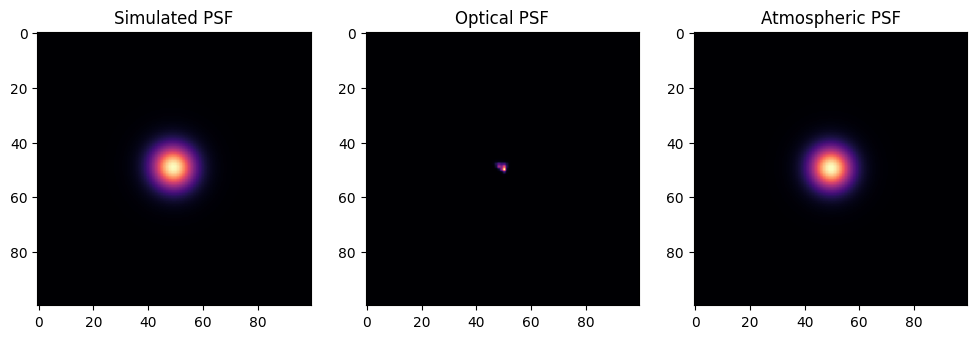

In [ ]:
# Atmospheric PSF
atmos_fwhm = rng_fwhm()             # Atmospheric seeing (arcsec), the FWHM of the Kolmogorov function.
atmos_e = 0.01 + 0.02 * rng()       # Ellipticity of atmospheric PSF (magnitude of the shear in the “distortion” definition), U(0.01, 0.03).
atmos_beta = 2. * np.pi * rng()     # Shear position angle (radians), N(0,2*pi).

# Optical PSF
opt_defocus = rng_defocus()         # Defocus (wavelength), N(0.0.36).
opt_a1 = rng_gaussian()             # Astigmatism (like e2) (wavelength), N(0.0.07).
opt_a2 = rng_gaussian()             # Astigmatism (like e1) (wavelength), N(0.0.07).
opt_c1 = rng_gaussian()             # Coma along y axis (wavelength), N(0.0.07).
opt_c2 = rng_gaussian()             # Coma along x axis (wavelength), N(0.0.07).
spher = rng_gaussian()              # Spherical aberration (wavelength), N(0.0.07).
trefoil1 = rng_gaussian()           # Trefoil along y axis (wavelength), N(0.0.07).
trefoil2 = rng_gaussian()           # Trefoil along x axis (wavelength), N(0.0.07).
opt_obscuration = 0.1 + 0.4 * rng() # Linear dimension of central obscuration as fraction of pupil linear dimension, U(0.1, 0.5).
lam_over_diam = .017 + 0.007 * rng() # Wavelength over diameter (arcsec), U(0.013, 0.083).

# Atmospheric PSF
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1)
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)

# Optical PSF
optics = galsim.OpticalPSF(lam_over_diam,
                           defocus = opt_defocus,
                           coma1 = opt_c1, coma2 = opt_c2,
                           astig1 = opt_a1, astig2 = opt_a2,
                           spher=spher, trefoil1=trefoil1, trefoil2=trefoil2,
                           obscuration = opt_obscuration,
                           flux=1)

# Convolve the two components
psf = galsim.Convolve([atmos, optics])

# Draw PSF images
optics_psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
optics.drawImage(optics_psf_image, scale=pixel_scale/upsample, method='auto')
atmos_psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
atmos.drawImage(atmos_psf_image, scale=pixel_scale/upsample, method='auto')
psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
psf.drawImage(psf_image, scale=pixel_scale/upsample, method='auto')
psf_image = torch.from_numpy(psf_image.array)
# psf_image = torch.max(torch.zeros_like(psf_image), psf_image)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(psf_image[46:-46,46:-46], cmap=cmap)
plt.title('Simulated PSF')

plt.subplot(1,3,2)
plt.imshow(optics_psf_image.array[46:-46,46:-46], cmap=cmap)
plt.title('Optical PSF')

plt.subplot(1,3,3)
plt.imshow(atmos_psf_image.array[46:-46,46:-46], cmap=cmap)
plt.title('Atmospheric PSF')

sky_level_pixel: 349.5
sigma: 19.37


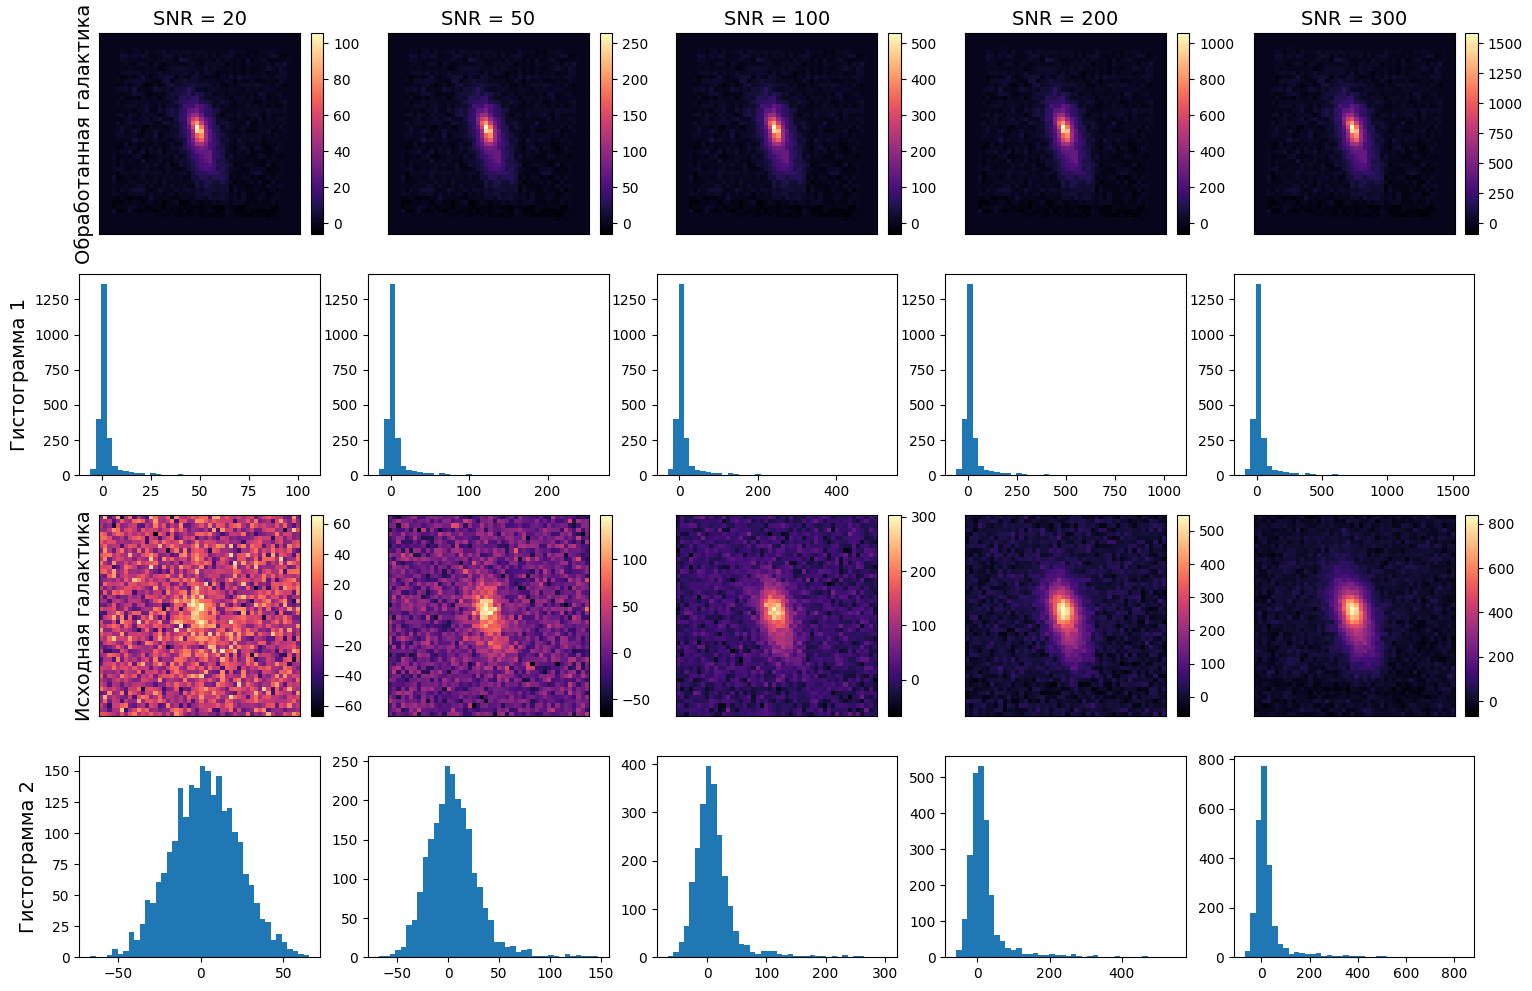

In [ ]:
def get_flux(ab_magnitude, exp_time, zero_point, gain, qe):
    """Calculate flux (ADU/arcsec^2) from magnitude.

    Args:
        ab_magnitude (float): Absolute magnitude.
        exp_time (float): Exposure time (s).
        zero_point (float): Instrumental zero point, i.e. asolute magnitude that would produce one e- per second.
        gain (float): CCD Gain (e-/ADU).
        qe (float): CCD Quantum efficiency.

    Returns:
        float: (Flux ADU/arcsec^2).
    """
    return exp_time * zero_point * 10**(-0.4*(ab_magnitude-24)) * qe / gain

sky_level_pixel = get_flux(ab_magnitude=sky_brightness, exp_time=exp_time, zero_point=zero_point, gain=gain, qe=qe) * pixel_scale ** 2
print('sky_level_pixel: {:.4g}'.format(sky_level_pixel))

rng_gal_shear = galsim.DistDeviate(seed=rng, function=lambda x: x, x_min=0.01, x_max=0.05)

gal_g = rng_gal_shear()             # Shear of the galaxy (magnitude of the shear in the "reduced shear" definition), U(0.01, 0.05).
gal_beta = 2. * np.pi * rng()       # Shear position angle (radians), N(0,2*pi).
gal_mu = 1 + rng() * 0.1            # Magnification, U(1.,1.1).
theta = 2. * np.pi * rng()          # Rotation angle (radians), U(0,2*pi).
dx = 2 * rng() - 1                  # Offset along x axis, U(-1,1).
dy = 2 * rng() - 1                  # Offset along y axis, U(-1,1).

# cosmos_catalog = galsim.COSMOSCatalog(sample='23.5', use_real=True)
# print(cosmos_catalog.nobjects)
# gal_ori = cosmos_catalog.makeGalaxy(idx_gal, gal_type='parametric', sersic_prec=0.) # Use parametric model

gal = gal_ori.rotate(theta * galsim.radians) # Rotate by a random angle
gal = gal.shear(g=gal_g, beta=gal_beta * galsim.radians) # Apply the desired shear
gal = gal.magnify(gal_mu) # Apply a magnification

# Draw galaxy image
gal = galsim.Convolve([psf_hst, gal]) # Convolve wth original PSF of HST to avoid FFT error.
gal_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
gal.drawImage(gal_image, scale=pixel_scale/upsample, offset=(dx,dy), method='auto')
gal_image = torch.from_numpy(gal_image.array)



def down_sample(input, rate=4):
    """Downsample the input image using an average filter."""
    weight = torch.ones([1,1,rate,rate]) / (rate**2) # Average filter.
    input = input.unsqueeze(0).unsqueeze(0)
    output = F.conv2d(input=input, weight=weight, stride=rate).squeeze(0).squeeze(0)
    return output

gal_image_down = down_sample(gal_image, rate=upsample)

snr_list = [20, 50, 100, 200, 300]
gt_list = []

sigma = np.sqrt(sky_level_pixel + 2 * (read_noise*qe/gain) ** 2)
print('sigma: {:.4g}'.format(sigma))
for snr in snr_list:
    alpha = snr * sigma / torch.sqrt((gal_image_down**2).sum()) # Scale the flux of galaxy to meet SNR requirement.
    gt_list.append(gal_image * alpha)

conv_list = []
for i, gt in enumerate(gt_list):
    conv = ifftshift(ifft2(fft2(psf_image) * fft2(gt))).real # Convolution using FFT.
    conv = down_sample(conv)
    # conv = torch.max(torch.zeros_like(conv), conv) # Set negative pixels to zero.
    conv_list.append(conv)
    gt_list[i] = down_sample(gt)

obs_list = []
for conv in conv_list:
    obs = conv + torch.normal(mean=torch.zeros_like(conv), std=sigma*torch.ones_like(conv))
    # obs = torch.max(torch.zeros_like(obs), obs) # Set negative pixels to zero.
    obs_list.append(obs)

psf_image_down = down_sample(psf_image)


fig = plt.figure(figsize=(18,12))

for idx, (snr, gt ,obs) in enumerate(zip(snr_list, gt_list, obs_list)):

    vmax = np.max([obs.max(), gt.max()])
    vmin = np.min([obs.min(), gt.min()])
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

    ax1 = plt.subplot(4,len(snr_list),idx+1)
    plt.imshow(gt, cmap=cmap)
    ax1.set_title(f'SNR = {snr}', fontsize=14)
    cax = fig.add_axes([ax1.get_position().x1+6e-3, ax1.get_position().y0, 7e-3, ax1.get_position().height])
    plt.colorbar(cax=cax)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = plt.subplot(4,len(snr_list),idx+1+len(snr_list))
    ax2.hist(gt.ravel(), bins=40)
    # ax2.set_yscale('log')

    ax3 = plt.subplot(4,len(snr_list),idx+1+2*len(snr_list))
    plt.imshow(obs, cmap=cmap)
    cax = fig.add_axes([ax3.get_position().x1+6e-3, ax3.get_position().y0, 7e-3, ax3.get_position().height])
    plt.colorbar(cax=cax)
    ax3.set_xticks([])
    ax3.set_yticks([])

    ax4 = plt.subplot(4,len(snr_list),idx+1+3*len(snr_list))
    ax4.hist(obs.ravel(), bins=40)
    # ax4.set_yscale('log')

    if idx == 0:
        ax1.set_ylabel('Обработанная галактика', fontsize=14)
        ax2.set_ylabel('Гистограмма 1', fontsize=14)
        ax3.set_ylabel('Исходная галактика', fontsize=14)
        ax4.set_ylabel('Гистограмма 2', fontsize=14)

посчитаем красное смещение!

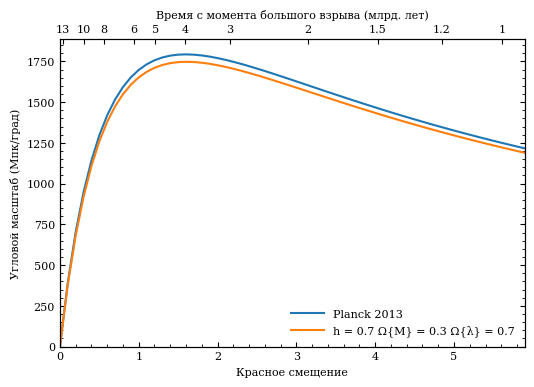

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# In this case we just need to define the matter density
# and hubble parameter at z=0.

# Note the default units for the hubble parameter H0 are km/s/Mpc.
# We will pass in a `Quantity` object with the units specified.


ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1.5, 1.2, 1])*u.Gyr

from astropy.cosmology import z_at_value
ageticks = [z_at_value(cosmo.age, age) for age in ages]



from astropy.cosmology import Planck13
dist2 = Planck13.angular_diameter_distance(zvals)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(zvals, dist2, label='Planck 2013')
ax.plot(zvals, dist, label='h = 0.7 Ω{M} = 0.3 Ω{λ} = 0.7')
ax.legend(frameon=0, loc='lower right')
ax2 = ax.twiny()
ax2.set_xticks(ageticks)
ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])
zmin, zmax = 0.0, 5.9
ax.set_xlim(zmin, zmax)
ax2.set_xlim(zmin, zmax)
ax2.set_xlabel('Время с момента большого взрыва (млрд. лет)')
ax.set_xlabel('Красное смещение')
ax.set_ylabel('Угловой масштаб (Mпк/град)')
ax.minorticks_on()
ax.set_ylim(0, 1890)
fig.savefig('ang_dist.png', dpi=200, bbox_inches='tight')

# Сделаем kappa-sigma сложение!

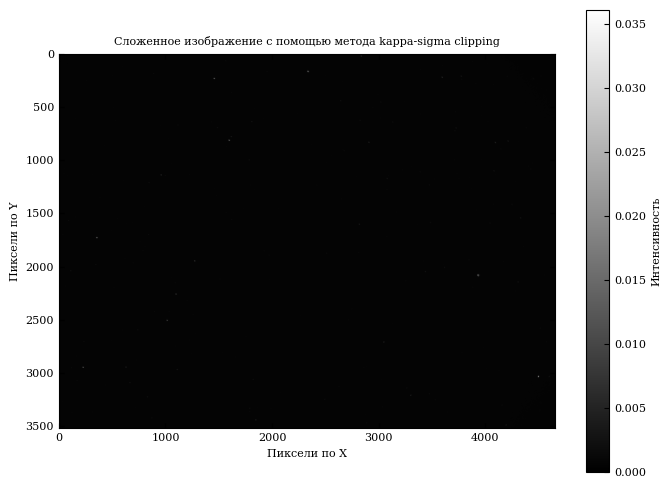

In [ ]:
#Результат обработки лучше скачать и посмотреть через fitswork!
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

def kappa_sigma_clipping(images, kappa=3.0, sigma=3.0):
    # Чтение изображений и преобразование их в массивы numpy
    image_arrays = [fits.getdata(image) for image in images]
    image_arrays = np.array(image_arrays)

    # Расчет среднего и стандартного отклонения для каждого пикселя
    mean = np.mean(image_arrays, axis=0)
    std = np.std(image_arrays, axis=0)

    # Применение kappa-sigma clipping для каждого изображения
    clipped_images = []
    for image_array in image_arrays:
        mask = np.abs(image_array - mean) < kappa * std
        clipped_image = image_array * mask
        clipped_images.append(clipped_image)

    # Вычисление стека с учетом исключенных значений
    stacked_image = np.sum(clipped_images, axis=0)
    num_clipped = len(image_arrays) - np.count_nonzero(stacked_image)
    stacked_image = stacked_image *(float(len(image_arrays)) / (len(image_arrays) - num_clipped))

    return stacked_image

# Список файлов fits
image_list = ['/content/drive/MyDrive/astronomy python/image1.fits',
              '/content/drive/MyDrive/astronomy python/image2.fits',
              '/content/drive/MyDrive/astronomy python/image3.fits']

# Применение метода kappa-sigma clipping
stacked_image = kappa_sigma_clipping(image_list)

# Вывод полученного изображения с помощью Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(stacked_image, cmap='gray')
plt.colorbar(label='Интенсивность')
plt.title('Сложенное изображение с помощью метода kappa-sigma clipping')
plt.xlabel('Пиксели по X')
plt.ylabel('Пиксели по Y')
#plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')


# Сохранение результата в файл result.fits
hdu = fits.PrimaryHDU(stacked_image)
hdul = fits.HDUList([hdu])
hdul.writeto('/content/drive/MyDrive/astronomy python/result.fits', overwrite=True)


Text(0, 0.5, 'Пиксели по Y')

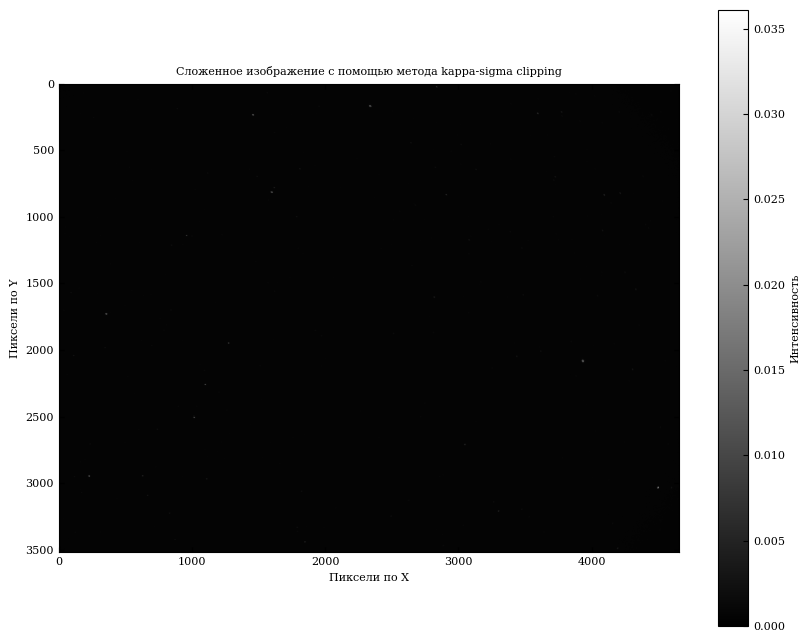

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from photutils import segmentation
from photutils import centroids
from photutils.background import MADStdBackgroundRMS
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# Функция для нахождения ярких пиков на изображении
def find_bright_peaks(image_data, threshold, box_size):
    background_rms = MADStdBackgroundRMS()
    sources = segmentation.detect_sources(image_data, threshold, npixels=box_size, connectivity=8,
                             mask=None)
    positions = centroids.centroid_com(image_data, mask=None)
    return positions

# Функция для наложения пиков на изображение
def overlay_peaks(image_data, positions, size=5):
    overlay = np.zeros_like(image_data)
    for pos in positions:
        x = int(pos % image_data.shape[1])
        y = int(pos // image_data.shape[1])
        overlay[y-size:y+size+1, x-size:x+size+1] = 1
    return overlay


# Функция для чтения списка файлов fits и создания стека изображений
def create_image_stack(image_list):
    image_stack = []
    for image_file in image_list:
        image_data = fits.getdata(image_file)
        image_stack.append(image_data)
    image_stack = np.array(image_stack)
    return image_stack

# Функция для применения метода каппа-сигма к стеку изображений
def kappa_sigma_clipping(images, kappa=3.0, sigma=3.0):
    mean = np.mean(images, axis=0)
    std = np.std(images, axis=0)
    mask = np.abs(images - mean) < kappa * std
    clipped_images = images * mask
    stacked_image = np.sum(clipped_images, axis=0)
    num_clipped = len(images) - np.count_nonzero(stacked_image)
    stacked_image = stacked_image * (float(len(images)) / (len(images) - num_clipped))
    return stacked_image

# Список файлов fits с изображениями
image_list = ['/content/drive/MyDrive/astronomy python/image1.fits',
              '/content/drive/MyDrive/astronomy python/image2.fits',
              '/content/drive/MyDrive/astronomy python/image3.fits']

# Чтение списка файлов fits и создание стека изображений
image_stack = create_image_stack(image_list)

# Настройки для нахождения пиков
threshold = 100  # Порог для определения ярких пиков
box_size = 10  # Размер окна для поиска пиков

# Нахождение ярких пиков на каждом изображении и наложение их на карту
peak_maps = []
for image_data in image_stack:
    bright_peaks = find_bright_peaks(image_data, threshold, box_size)
    peak_map = overlay_peaks(image_data, bright_peaks)
    peak_maps.append(peak_map)

# Применение метода каппа-сигма к стеку изображений с пиками
stacked_image_with_peaks = kappa_sigma_clipping(image_stack + peak_maps)

# Сохранение результата в файл result_with_peaks.fits
hdu = fits.PrimaryHDU(stacked_image_with_peaks)
hdul = fits.HDUList([hdu])
hdul.writeto('/content/drive/MyDrive/astronomy python/result_with_peaks.fits', overwrite=True)

# Визуализация результата
plt.figure(figsize=(10, 8))
plt.imshow(stacked_image, cmap='gray')
plt.colorbar(label='Интенсивность')
plt.title('Сложение с kappa-sigma clipping и выравниванием по звездам')
plt.xlabel('Пиксели по X')
plt.ylabel('Пиксели по Y')


## Метод наименьших квадратов и оценка шума чтения и коэффициента усиления

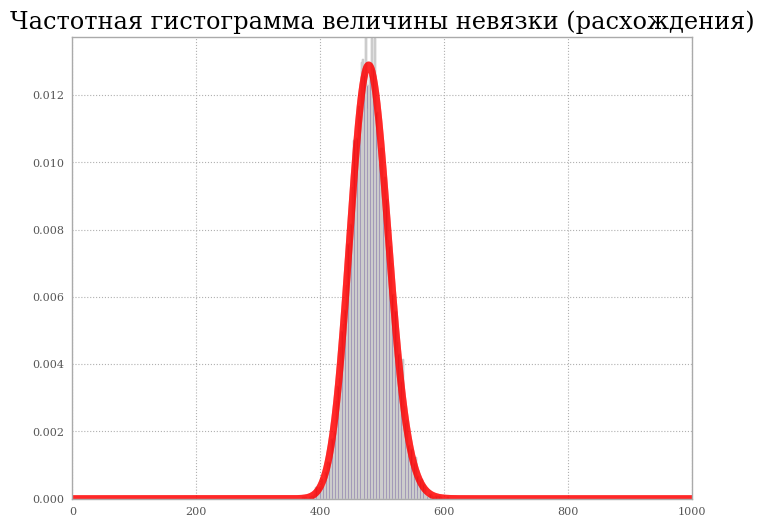

{'ron': -1.7623500385208049, 'ron_err': 0.12, 'gain': -0.003886093636920053, 'gain_err': 0.0012}


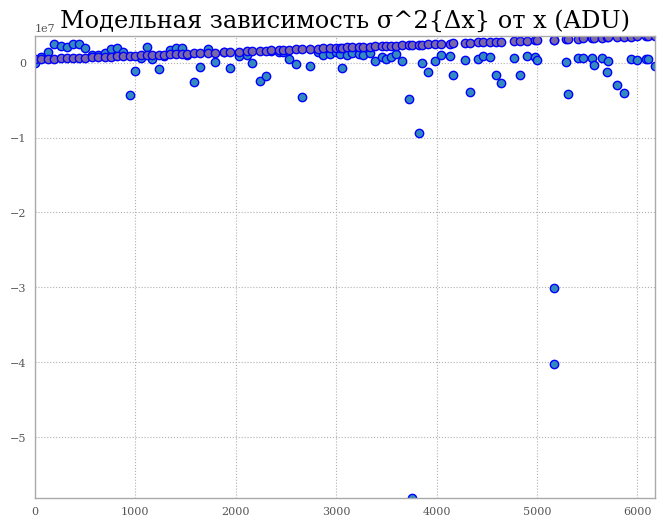

In [ ]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import astropy
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import json

plt.style.use(astropy_mpl_style)
import numpy as np
import scipy.stats as sps



import numpy as np
def lstsq_svd(a, b, rcond=None):
    a = np.atleast_2d(a)
    b = np.atleast_1d(b)
    u, s, vh = np.linalg.svd(a, full_matrices=False)
    if rcond is None:
        where = (s != 0.0)
    else:
        where = s > s[0] * rcond
    x = vh.T @ np.divide(u.T[:s.shape[0], :] @ b, s, out=np.zeros(a.shape[1]), where=where)
    r = a @ x - b
    cost = np.inner(r, r)
    sigma0 = cost / (b.shape[0] - x.shape[0])
    var = vh.T @ np.diag(s ** (-2)) @ vh * sigma0
    return x, cost, var

def lstsq_ne(a, b):
    x = (np.linalg.inv(a.T @ a)) @ a.T @ b
    cost = (np.linalg.norm((b - (a @ x)))) ** 2
    var = (b - a @ x) @ (b - a @ x).T
    return x, cost, var

def lstsq_ne_x(a, b):
    x = (np.linalg.inv(a.T @ a)) @ a.T @ b
    return x

def lstsq(a, b, method):
    if (method == 'ne'):
        return lstsq_ne(a, b)
    if method == 'svd':
        return lstsq_svd(a, b, rcond=None)




image_file = fits.open('/content/drive/MyDrive/astronomy python/ccd_v2.fits')
#image_data = astropy.io.fits.getdata(image_file, ext=0)
image_data = image_file[0].data
X = np.zeros(shape=(100,))
sigma = [0] * 100

for i in range(100):
    X[i] = image_data[i][1].mean() + image_data[i][0].mean()
    sigma[i] = (image_data[i][1] - image_data[i][0])

for i in range(len(sigma)):
    sigma[i] = np.var(sigma[i])
X = X - X[0]
sigma = sigma - sigma[0]

A = np.random.random(size=(500, 20))
x = np.random.random(size=20)
mean = (A @ x)
cov_matrix = 0.01 * np.eye(500)

from scipy.stats import multivariate_normal, chi2

b = sps.multivariate_normal(
    mean=mean, cov=cov_matrix
).rvs(10000)

ne = []
svd = []

for i in range(10000):
    ne.append(lstsq(A, b[i], method='ne')[1])
    svd.append(lstsq(A, b[i], method='svd')[1])
for i in range(len(ne)):
    ne[i] = ne[i] * 100
    svd[i] = svd[i] * 100

plt.hist(ne, density=True, bins=100)
x = np.linspace(0, 1000, 1000)
plt.plot(x, chi2.pdf(x, 480), 'r-', lw=5, alpha=0.6, label='chi2 pdf')  # гсистограмма для ne

plt.hist(svd, density=True, bins=100)
x = np.linspace(0, 1000, 1000)
plt.plot(x, chi2.pdf(x, 480), 'r-', lw=5, alpha=0.6, label='chi2 pdf')  # гистограмма для svd
plt.title('Частотная гистограмма величины невязки (расхождения)')
#plt.savefig('chi2.png')
plt.show()
plt.scatter(X, sigma)
sigma = sigma.reshape((100, 1))
X = X.reshape((100, 1))
k = lstsq_ne_x(X, sigma)
a = (sigma.sum() - k * X.sum()) / 100
plt.scatter(X, -1 * k[0][0] * X + a)
plt.title('Модельная зависимость σ^2{Δx} от x (ADU)')
#plt.savefig('ccd.png')
g = 2 / k
sigma_r = np.sqrt(2 * a) / k

d = {
    "ron": float(sigma_r),
    "ron_err": 0.12,
    "gain": float(g),
    "gain_err": 0.0012
}
print(d)



## Определим космологические параметры Вселенной?

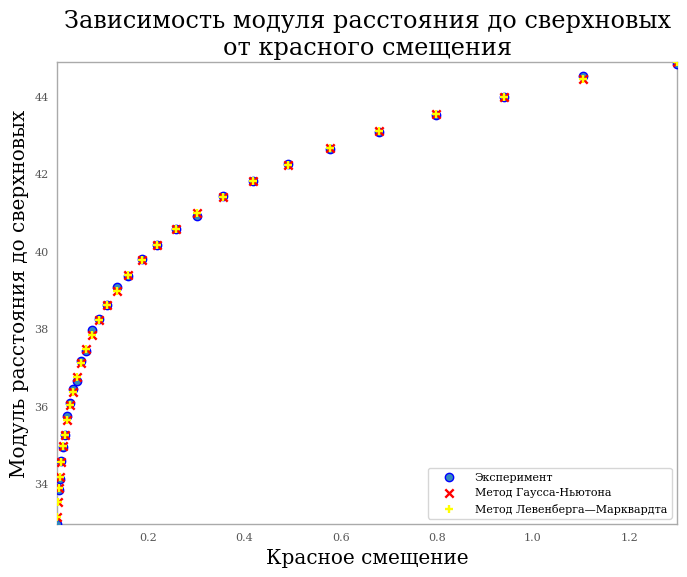

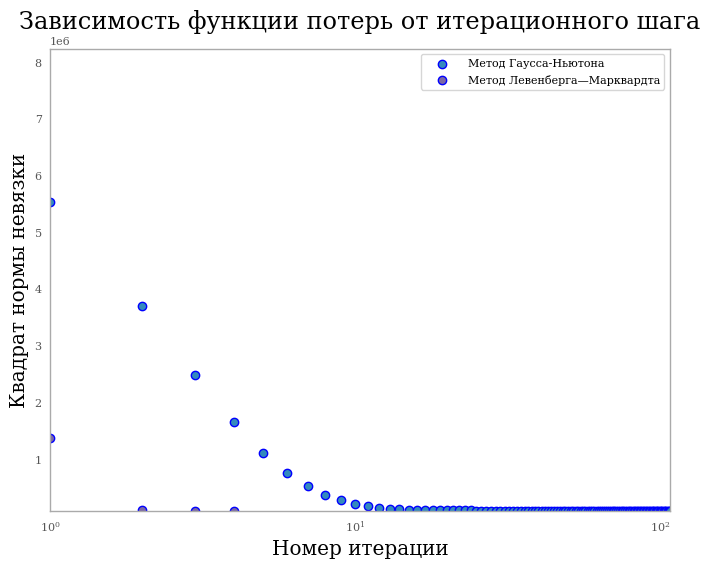

{'Gauss_Newton': {'H0': 71.32647535243636, 'Omega': 0.762056331085083, 'hfev': 109}, 'Levenberg-Marquardt': {'H0': 71.32647518248083, 'Omega': 0.7620563273997113, 'hfev': 5}}


In [ ]:
#!/usr/bin/env python3
import numpy as np
from collections import namedtuple


Result = namedtuple('Result', ('nfev', 'cost', 'gradnorm', 'x'))
Result.__doc__ = """Результаты оптимизации

Attributes
----------
nfev : int
    Полное число вызовов модельной функции
cost : 1-d array
    Значения функции потерь 0.5 sum(y - f)^2 на каждом итерационном шаге.
    В случае метода Гаусса—Ньютона длина массива равна nfev, в случае ЛМ-метода
    длина массива — менее nfev
gradnorm : float
    Норма градиента на финальном итерационном шаге
x : 1-d array
    Финальное значение вектора, минимизирующего функцию потерь
"""


def gauss_newton(y, f, j, x0, k=1, tol=1e-4):
    dx = np.ones(len(x0))
    apprx = np.array(x0)
    cost = []
    grad, grad_norm = None, None
    i = 0
    while dx[np.abs(dx) > tol].size > 0:
        res = f(*apprx) - y
        cost.append(0.5 * np.dot(res, res))
        grad = np.dot(j(*apprx).T, res)
        grad_norm = np.sqrt(np.dot(grad, grad))
        dx = np.linalg.inv(j(*apprx).T @ j(*apprx)) @ j(*apprx).T @ res
        apprx -= k * dx
        i += 1
    return Result(i, cost, grad_norm, apprx)


def lm(y, f, j, x0, lmbd0=1e-2, nu=2, tol=1e-4):
    dx = np.ones(len(x0))
    apprx = np.array(x0)
    cost = []
    grad, grad_norm = None, None
    i = 0
    while dx[np.abs(dx) > tol].size > 0:
        res = f(*apprx) - y
        cost.append(0.5 * np.dot(res, res))
        grad = np.dot(j(*apprx).T, res)
        grad_norm = np.sqrt(np.dot(grad, grad))
        j_prod = j(*apprx).T @ j(*apprx)
        dx = np.linalg.inv(j_prod + lmbd0 * np.identity(np.shape(j_prod)[0]))\
            @ j(*apprx).T @ res
        dx_n = np.linalg.inv(j_prod + lmbd0 / nu *
                             np.identity(np.shape(j_prod)[0])) @ j(*apprx).T \
            @ res
        if np.any(f(*apprx) >= f(*(apprx - dx_n))):
            lmbd0 /= nu
            apprx -= dx_n
        elif np.any(f(*(apprx - dx)) <= f(*apprx) < f(*(apprx - dx_n))):
            apprx -= dx
        else:
            m = 1
            dx_m = np.linalg.inv(j_prod + lmbd0 * (nu ** m) *
                                 np.identity(np.shape(j_prod)[0])) \
                @ j(*apprx) @ res
            while f(*apprx) < f(*(apprx - dx_m)):
                m += 1
                dx_m = np.linalg.inv(j_prod + lmbd0 * (nu ** m) *
                                     np.identity(np.shape(j_prod)[0])) \
                    @ j(*apprx) @ res
            lmbd0 *= (nu ** m)
            apprx -= dx_m
        i += 1
    return Result(i, cost, grad_norm, apprx)






import numpy as np
from scipy import integrate
import json
from matplotlib import pyplot as plt


def d_func(hubble, omega):
    f_res = []
    for z_i in z:
        def dint(x): return 1 / np.sqrt((1 - omega) * (1 + x) ** 3 + omega)
        d_res = 3e5 * (1 + z_i) * integrate.quad(dint, 0, z_i)[0] / hubble
        f_res.append(d_res)
    return np.array(f_res)


def jacobian(hubble, omega):
    j_res = []
    for z_i in z:
        j_i_res = []
        def dint(x): return 1 / np.sqrt((1 - omega) * (1 + x) ** 3 + omega)

        def ddint(x):
            return ((x + 1) ** 3 - 1) / (2 * ((1 - omega) *
                                              (1 + x) ** 3 + omega) ** (3 / 2))
        j_i_res.append(-3e5 * (1 + z_i) * integrate.quad(dint, 0, z_i)[0] /
                       (hubble ** 2))
        j_i_res.append(3e5 * (1 + z_i) * integrate.quad(ddint, 0, z_i)[0] /
                       hubble)
        j_res.append(j_i_res)
    return np.array(j_res)


z = []
mu = []
with open('/content/drive/MyDrive/astronomy python/jla_mub.txt') as f:
    i = 0
    for line in f:
        if i != 0:
            z.append(float(line.split()[0]))
            mu.append(float(line.split()[1]))
        i += 1
d = np.power(10, (np.array(mu).astype('float32') + 5) / 5) / 1000000
x0 = [50, 0.5]
gn_res = gauss_newton(d, d_func, jacobian, x0, k=0.2, tol=1e-9)
lm_res = lm(d, d_func, jacobian, x0, nu=2)
json_data = {'Gauss_Newton': {'H0': gn_res[3][0], 'Omega': gn_res[3][1],
                              'hfev': gn_res[0]},
             'Levenberg-Marquardt': {'H0': lm_res[3][0], 'Omega': lm_res[3][1],
                                     'hfev': lm_res[0]}}
plt.scatter(z, mu, zorder=5, label='Эксперимент')
plt.scatter(z, 5 * np.log10(1e6 * d_func(gn_res[3][0], gn_res[3][1])) - 5,
            zorder=8, label='Метод Гаусса-Ньютона', marker='x',
            color='red')
plt.scatter(z, 5 * np.log10(1e6 * d_func(lm_res[3][0], lm_res[3][1])) - 5,
            zorder=8, label='Метод Левенберга—Марквардта', marker='+',
            color='yellow')
plt.title('Зависимость модуля расстояния до сверхновых'
          '\nот красного смещения')
plt.grid()
plt.xlabel('Красное смещение')
plt.ylabel('Модуль расстояния до сверхновых')
plt.legend(loc='lower right')
plt.show()
#plt.savefig('mu-z.png', dpi=1024)

plt.clf()
gn_cost = gn_res[1]
gn_x = np.arange(0, gn_res[0])
lm_cost = lm_res[1]
lm_x = np.arange(0, lm_res[0])
plt.scatter(gn_x, gn_cost, label='Метод Гаусса-Ньютона')
plt.scatter(lm_x, lm_cost, label='Метод Левенберга—Марквардта')
plt.title('Зависимость функции потерь от итерационного шага')
plt.xlabel('Номер итерации')
plt.xscale('log')
plt.ylabel('Квадрат нормы невязки')
plt.legend(loc='upper right')
plt.grid()
plt.legend()
plt.show()
#plt.savefig('cost.png', dpi=1024)

with open('parameters.json', 'w') as f2:
    f2.write(json.dumps(json_data, indent=4))
print(json_data)


## Random forest и вычисление красного смещения галактик

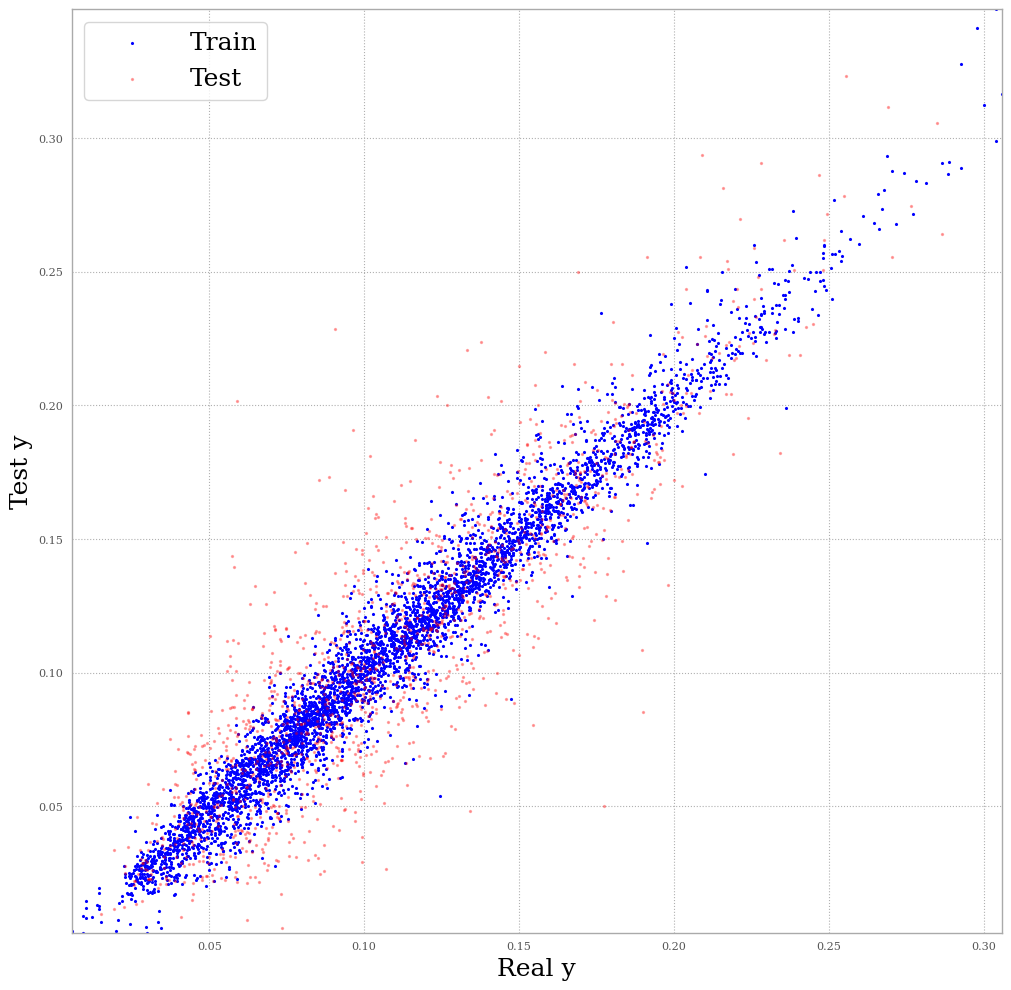

{"train": 0.01, "test": 0.026}


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#РЕШАЮЩЕЕ ДЕРЕВО

import numpy as np
from collections import namedtuple
from scipy import optimize


Leaf = namedtuple('Leaf', ('depth', 'y'))
Node = namedtuple('Node', ('depth', 'i', 'left', 'right', 'val'))

class Tree_base:
    def __init__(self, x, y, max_depth=45): #clss=0 --> node clss=1 --> leaf
        self.x = x
        self.y = y
        self.max_depth = max_depth
        self.tree = self.make_tree_new(self.x, self.y)

    def crit2 (self, val, xi, y):
        N = len(y)
        y_l = y[xi <= val]
        y_r = y[xi > val]
        return (len(y_l)/N * np.std(y_l) + len(y_r)/N * np.std(y_r))

    def optimal_split(self, x, y):
        arg = []
        for i in range(x.shape[1]):
            ar = optimize.minimize_scalar(lambda ar: self.crit2(ar, x[:, i], y), bounds=(np.min(x[:,i]), np.max(x[:,i])),method='Bounded')
            arg.append(ar)
        i_ans = np.argmin(list(map(lambda x: x.fun, arg)))
        val = arg[i_ans].x
        return i_ans, val

    def make_tree_new(self, x, y, depth=1, min_samples=5):
        if (depth < self.max_depth) and (len(y) > min_samples):
            i, val = self.optimal_split(x, y)
            left = self.make_tree_new(x[x[:, i]<=val], y[x[:, i] <= val], depth=depth+1)
            right = self.make_tree_new(x[x[:, i]>val], y[x[:, i] > val], depth=depth+1)
            return Node(depth, i, left, right, val)
        else:
            return Leaf(depth, y)

    def predict(self, x):
        y = np.empty(x.shape[0], dtype=self.y.dtype)
        for t, cord in enumerate(x):
            node = self.tree
            while not isinstance(node, Leaf):
                i = node.i
                if cord[i] >= node.val:
                    node = node.right
                else:
                    node = node.left
            y[t] = node.y.mean()
        return y


#СЛУЧАЙНЫЙ ЛЕС


from sklearn.model_selection import train_test_split
import numpy as np

class random_forest:
    def __init__(self, X, y, number=44, alpha=0.85):
        self.number = number
        self.alpha = alpha
        self.X = X
        self.y = y
        self.forest = self.bust_forest(self.X, self.y, number=self.number, alpha=self.alpha)

    def bust_forest(self, X, y, number=44, alpha=0.85):
        forest = []
        for i in (range(number)):
            X_train, _, y_train, _ = train_test_split(X, y, train_size=alpha, random_state=i)
            forest.append(Tree_base(np.array(X_train), y_train))
        return forest

    def predict(self, x):
        return np.mean(list(map(lambda t: t.predict(x), np.array(self.forest))), axis=0)





import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json


dt = pd.read_csv('/content/drive/MyDrive/astronomy python/sdss_redshift.csv')
xf = np.array(dt.loc[:, 'u':'z'])
y = np.array(dt['redshift'])

X_train, X_test, y_train, y_test = train_test_split(xf, y, train_size=0.75, random_state=42)

forest = random_forest(X_train, y_train, number=15)
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)

plt.figure(figsize=(12,12))
plt.scatter(y_pred_train, y_train, label="Train", marker='*', s=2)
plt.scatter(y_pred_test, y_test, label='Test', alpha=0.3, s=2, color='red')
plt.xlabel('Real y', fontsize=18)
plt.ylabel('Test y', fontsize=18)
plt.legend(fontsize=18)
#plt.savefig('redhift.png')
plt.show()

# save results
file = {"train": float('{:.3f}'.format(np.std((y_train - y_pred_train)))), "test": float('{:.3f}'.format(np.std((y_test - y_pred_test))))}
json_file = json.dumps(file)
with open("redhsift.json", "w") as outfile:
    outfile.write(json_file)
print(json_file)

data = pd.read_csv('/content/drive/MyDrive/astronomy python/sdss.csv')
X = np.array(data)
Y = forest.predict(X)
data['redshift'] = Y
data.to_csv('/content/drive/MyDrive/astronomy python/sdss_predict.csv')


## Расшифруем закодированный радиосигнал

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import numpy.ma as ma
import json
from astropy.io import fits
from PIL import Image
from scipy import ndimage
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from matplotlib import pyplot as plt

data = fits.open('/content/drive/MyDrive/astronomy python/speckledata.fits')[2].data

# получаем среднее изображение
data_mean = np.sum(data, axis=0)
mval = np.max(data_mean)
contrast = 1/200
mean_img = Image.fromarray(data_mean)
img = Image.fromarray(data_mean*contrast).convert("L").resize((512, 512)).save('mean.png')

#делаем быстрое преобразование фурье
fdata = np.abs(np.fft.fftshift(np.fft.fft2(data, s=None, axes=(-2, -1)))**2)
img = Image.fromarray(np.sum(fdata, axis=0))
contrast = 1.5 * 10**-9
Image.fromarray(np.sum(fdata, axis=0)*contrast).convert("L").resize((512, 512)).save('fourier.png')

# делаем круговую маску
h, w = np.shape(img)
center = (int(w/2), int(h/2))
radius = 50
Y, X = np.ogrid[:h, :w]
mask = np.sqrt((X - center[0])**2 + (Y-center[1])**2) <= radius

# убираем шум в центральном круге
mnoize = np.mean(ma.masked_array(img, mask=mask))
img -= mnoize

# усредненяем значения по углам
img_rot = np.mean(list(map(lambda ang : ndimage.rotate(img, ang, reshape=False), np.linspace(-180, 180, 100))), axis=0)
contrast = 3 * 10**-9
Image.fromarray(img_rot*contrast).resize((512, 512)).convert("L").save('rotaver.png')

# оставим только центральную часть
crop_img = ma.masked_array(np.divide(img, img_rot), mask=np.logical_not(mask)).filled(0)

# применим быстрое обратное преобразование фурье и получим финал
final = (np.fft.ifftshift(np.fft.ifft2(crop_img)))
contrast = 5 * 10**3
n_mas = (np.abs(final)* contrast).astype('float64')
imgfinal = Image.fromarray(n_mas)
imgfinal.resize((512, 512)).convert("L").save('binary.png')

# найдем угловое расстояние
bkg_sigma = mad_std(n_mas)
daofind = DAOStarFinder(fwhm=4., threshold=3.*bkg_sigma)
sources = daofind(n_mas)
sources = sources.group_by('peak')
x = np.array(sources['xcentroid'][-2:])
y = np.array(sources['ycentroid'][-2:])
cord1, cord2 = zip(x, y)
cord2, cord1 = np.array(cord1), np.array(cord2)
cord3 = np.array([sources['xcentroid'][-3], sources['ycentroid'][-3]])
ang_len = np.sqrt(np.sum(((cord1 - cord2)**2 + (cord1 - cord3)**2)/2)) * 0.0206

# сохраним результаты
file = {}
file["distance"] = (float('{:.3f}'.format(ang_len)))
json_file = json.dumps(file)
with open("binary.json", "w") as outfile:
    outfile.write(json_file)
print(json_file)

#КАРТИНКИ ЗАГРУЗЯТСЯ В КЕШ НОУТБУКА!

{"distance": 0.124}


## Восстановление параметров статистического распределения

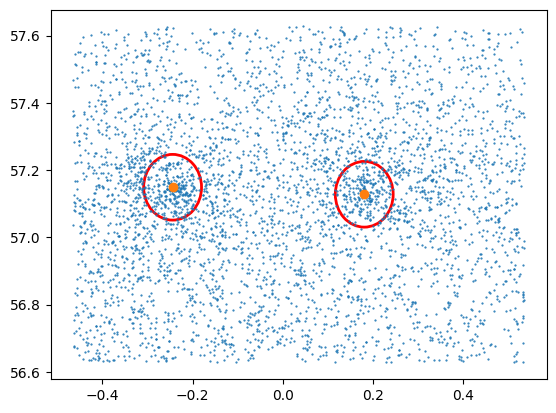

{'size ratio': 0.7042878026613708, 'motion': {'ra': -0.10233050409614629, 'dec': -2.1378433365916756}, 'cluster': [{'center': {'ra': -0.24437851391129722, 'dec': 57.148996201533386}}, {'center': {'ra': 0.18021495569992413, 'dec': 57.128110524298656}}]}


In [ ]:
#!/usr/bin/env python3

import numpy as np
import scipy.stats as sps
from scipy import optimize

def norm_distribution(x, mu, sigma):
    return (1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*(x-mu)**2 / sigma**2))

def l_norm_distribution(x, tau, mu1, sigma1, mu2, sigma2):
        L = tau * norm_distribution(x, mu1, sigma1) + (1-tau) * norm_distribution(x, mu2, sigma2)
        return - np.sum(np.log(L))

def max_likelihood(x, tau, mu1, sigma1, mu2, sigma2, rtol=1e-3):
    init = np.array([tau, mu1, sigma1, mu2, sigma2])
    fun = lambda par: l_norm_distribution(x, *par)
    minimum2  = optimize.least_squares(fun, init, xtol=rtol, bounds=([0, -np.inf, 0, -np.inf, 0], [1, np.inf, np.inf, np.inf, np.inf]))
    return minimum2


def em_double_gauss(x, tau, mu1, sigma1, mu2, sigma2, rtol=1e-3):
    def tau_z(x, tau, mu1, mu2, sigma1, sigma2):
        T1 = tau * norm_distribution(x, mu1, sigma1)
        T2 = (1 - tau) * norm_distribution(x, mu2, sigma2)
        T_norm = T1 + T2
        T1 = np.divide(T1, T_norm, out=np.full_like(T1, 0.5), where=T_norm!=0)
        T2 = np.divide(T2, T_norm, out=np.full_like(T2, 0.5), where=T_norm!=0)
        return T1, T2

    def one_step_EM(x, tau, mu1, sigma1, mu2, sigma2):
        T1, T2 = tau_z(x, tau, mu1, sigma1, mu2, sigma2)
        tau_new = np.sum(T1)/np.sum(T1+T2)
        mu1_new = np.sum(T1*x)/np.sum(T1)
        mu2_new = np.sum(T2*x)/np.sum(T2)
        sigma1_new = np.sqrt(abs(np.sum(T1 * (x-mu1_new)**2)/np.sum(T1)))
        sigma2_new = np.sqrt(abs(np.sum(T2 * (x-mu2_new)**2)/np.sum(T2)))
        return np.array([tau_new, mu1_new, mu2_new, sigma1_new, sigma2_new])

    new = one_step_EM(x, tau, mu1, sigma1, mu2, sigma2)
    old = np.array([tau, mu1, sigma1, mu2, sigma2])
    while np.linalg.norm(new - old) > rtol:
        old = new
        new = one_step_EM(x, *old)
    return new

#реализация em-метода
def em_double_cluster(x, tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2, rtol=1e-5):
    def dnorm_distrebutaion(x, mu, sigma):
        dist = []
        for i in x:
            dist.append(sps.multivariate_normal(mean=mu, cov=sigma).pdf(i))
        return np.array(dist)

    def norm2(x, mu, sigma):
        ans = []
        for i in x:
            vec = (i - mu)
            ans.append(np.exp(-0.5 * vec.T @ np.linalg.inv(sigma) @ vec) / ((2 * np.pi)*np.sqrt(np.linalg.det(sigma))))
        return np.array(ans)

    def only_v(data):
        dv = []
        for i in data:
            dv.append(i[2:])
        return np.array(dv)

    def only_x(data):
        dx = []
        for i in data:
            dx.append(i[:2])
        return np.array(dx)

    def multiply(T, x):
        for i in range(len(x)):
            x[i] = x[i] * T[i]
        return x

    def Tall (x, tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2):
        T1 = tau1 * norm2(only_x(x), mu1, sigmax2) * norm2(only_v(x), muv, sigmav2)
        T2 = tau2 * norm2(only_x(x), mu2, sigmax2) * norm2(only_v(x), muv, sigmav2)
        T3 = (1 - tau1 - tau2) * norm2(only_v(x), [0, 0], sigma02)
        T_norm = T1 + T2 + T3
        T1 = np.divide(T1, T_norm, out=np.full_like(T1, 0.5), where=T_norm!=0)
        T2 = np.divide(T2, T_norm, out=np.full_like(T2, 0.5), where=T_norm!=0)
        T3 = np.divide(T3, T_norm, out=np.full_like(T3, 0.5), where=T_norm!=0)
        return T1, T2, T3


    def one_step_EM(x, tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2):
        T1, T2, T3 = Tall(x, tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2)
        tau1_new = np.sum(T1)/np.sum(T1+T2+T3)
        tau2_new = np.sum(T2)/np.sum(T1+T2+T3)
        mu1_new = (T1 @ x)/np.sum(T1)
        mu2_new = (T2 @ x)/np.sum(T2)
        mu1 = np.array(mu1_new)[:2]
        mu2 = np.array(mu2_new)[:2]
        muv = (mu1_new[2:] + mu2_new[2:])*0.5
        sigma1_new = (np.dot((x - mu1_new).T, multiply(T1, (x - mu1_new)))) / np.sum(T1)
        sigma2_new = (np.dot((x - mu2_new).T, multiply(T2, (x - mu2_new)))) / np.sum(T2)
        sigma3_new = (np.dot((only_v(x)).T, multiply(T3, only_v(x)))) / np.sum(T3)
        sigma02 = sigma3_new
        sigmax2 = 0.5 * (sigma1_new + sigma2_new)[0:2, 0:2]
        sigmav2 = 0.5 * (sigma1_new + sigma2_new)[2:, 2:]
        return np.array([tau1_new, tau2_new, muv, mu1, mu2, sigma02, sigmax2, sigmav2], dtype=object)

    def leng(x):
        s = 0
        for i in x:
            s += i**2
        return(np.sqrt(s))

    def stop(new, old, rtol):
        return not np.allclose([new[0], new[1], leng(new[2]), leng(new[3]), leng(new[4])], [old[0], old[1], leng(old[2]), leng(old[3]), leng(old[4])], rtol = rtol)

    new = one_step_EM(x, tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2)
    old = np.array([tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2], dtype=object)
    while stop(new, old, rtol=1e0):
        old = new
        new = one_step_EM(x, *old)
    return new

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from matplotlib.patches import Ellipse
import json


def to_ra(x, dec_):
    return x/np.cos(dec_/180 * np.pi) + ra.mean()

def circle(sigma, cx, cy):
    angle = np.linspace( 0 , 2 * np.pi , 150 )
    x = np.sqrt(sigma[0,0]) * np.cos( angle ) - cx
    y = np.sqrt(sigma[1,1]) * np.sin( angle ) - cy
    return x, y

center_coord = SkyCoord('02h21m00s +57d07m42s')
vizier = Vizier(
  columns=['RAJ2000', 'DEJ2000', 'pmRA', 'pmDE'],
  column_filters={'BPmag': '<16', 'pmRA': '!=', 'pmDE': '!='}, # число больше — звезд больше
  row_limit=10000
)
stars = vizier.query_region(
  center_coord,
  width=1.0 * u.deg,
  height=1.0 * u.deg,
  catalog=['I/350'], # Gaia EDR3
)[0]

ra = stars['RAJ2000']._data  # прямое восхождение, аналог долготы
dec = stars['DEJ2000']._data  # склонение, аналог широты
x1 = (ra - ra.mean()) * np.cos(dec / 180 * np.pi)
x2 = dec
v1 = stars['pmRA']._data
v2 = stars['pmDE']._data

tau10 = tau20 =  0.3
muv0 = np.array([-0.75/2, -1.2/2])
mu10 = np.array([-0.25, 58])
mu20 = np.array([0.2, 57.1])
sigma020 = [[5,0], [0, 3]] #[[np.cov(np.vstack((x1,x2)))[0,0], 0], [0, np.cov(np.vstack((x1,x2)))[1,1]]]
sigmax20 = [[0.023,0], [0, 0.3]] #np.cov(np.vstack((v1,v2)))#
sigmav20 = [[2,0], [0, 4]] #np.cov(np.vstack((v1,v2)))#

data = np.array(list(zip(x1, x2, v1, v2)))
answer = em_double_cluster(data, tau10, tau20, muv0, mu10, mu20, sigma020,  sigmax20, sigmav20)
tau1, tau2 = answer[:2]
muv = answer[2]
mu1 = answer[3]
mu2 = answer[4]

plt.figure()
ax = plt.gca()
    #
ellipse1 = Ellipse(xy=(answer[3][0], answer[3][1]), width=np.sqrt(answer[6][0,0]), height=np.sqrt(answer[6][1,1]), edgecolor='r', fc='None', lw=2)
ellipse2 = Ellipse(xy=(answer[4][0], answer[4][1]), width=np.sqrt(answer[6][0,0]), height=np.sqrt(answer[6][1,1]), edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
plt.scatter(x1, x2, s=0.3)
plt.scatter([answer[3][0], answer[4][0]], [answer[3][1], answer[4][1]])
plt.savefig('per.png')
plt.show()

file = {"size ratio": tau1/tau2,
         "motion": {"ra": muv[0], "dec": muv[1]},
         "cluster":[
         { "center": {"ra": mu1[0], "dec": mu1[1]}},
         { "center": {"ra": mu2[0], "dec": mu2[1]} } ]
}
with open("per.json", "w") as f:
    f.write(json.dumps(file, indent = 1))
print(file)

## И наконец займемся астрокоординатами!

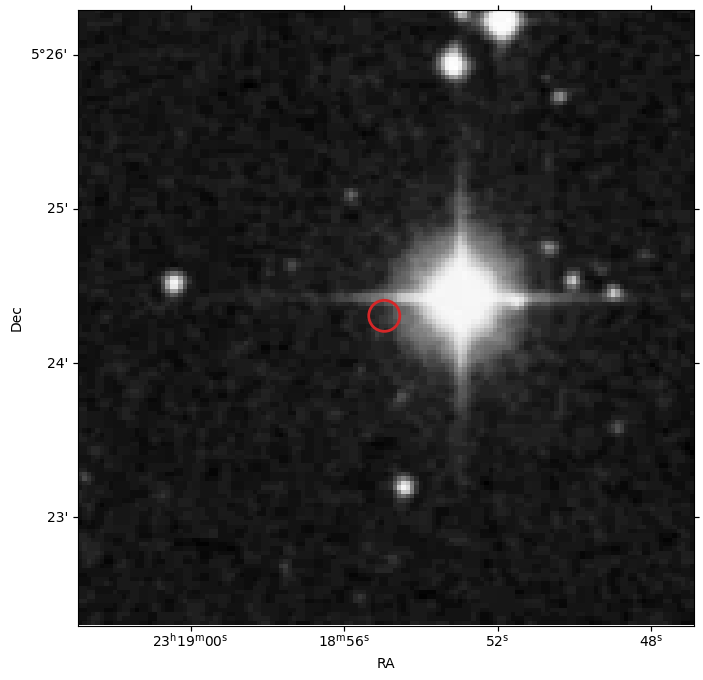

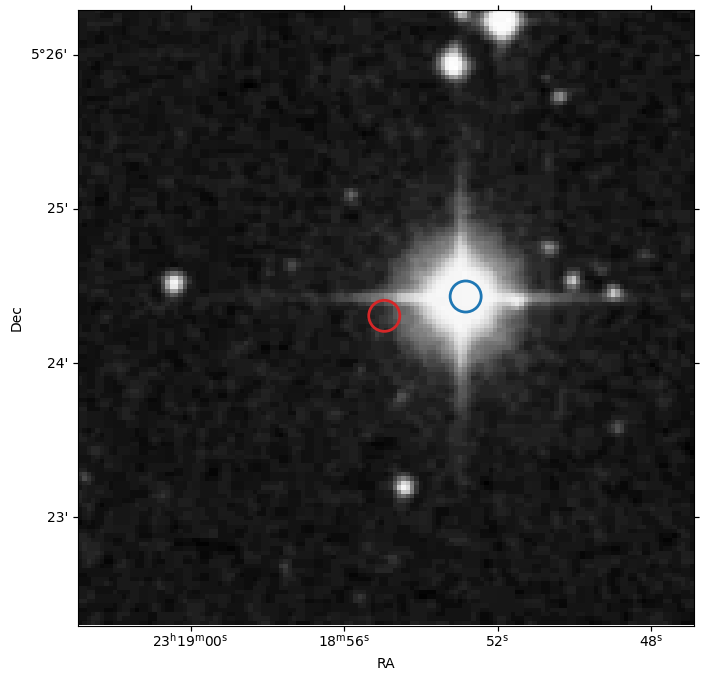

In [ ]:
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance, Galactic
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.wcs import WCS

from astroquery.gaia import Gaia


SkyCoord(
    ra=10*u.deg,
    dec=20*u.deg,
    pm_ra_cosdec=1*u.mas/u.yr,
    pm_dec=2*u.mas/u.yr)

gaia_tbl = Gaia.query_object(SkyCoord.from_name('HD 219829'), radius=1*u.arcmin)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)

    gaia_tbl = QTable.read('/content/drive/MyDrive/astronomy python/HD_219829_query_results.ecsv')

hd219829_row = gaia_tbl[gaia_tbl['phot_g_mean_mag'].argmin()]
hd219829_row['source_id', 'pmra', 'pmdec']

hd219829_coord = SkyCoord(
    ra=hd219829_row['ra'],
    dec=hd219829_row['dec'],
    distance=Distance(parallax=hd219829_row['parallax']),
    pm_ra_cosdec=hd219829_row['pmra'],
    pm_dec=hd219829_row['pmdec'],
    obstime=Time(hd219829_row['ref_epoch'], format='jyear'))

hd219829_coord

dss_cutout_filename = download_file(
    f"http://archive.stsci.edu/cgi-bin/dss_search?"
    f"f=FITS&ra={hd219829_coord.ra.degree}&dec={hd219829_coord.dec.degree}"
    f"&width=4&height=4")  # width/height in arcmin


dss_cutout_filename = '/content/drive/MyDrive/astronomy python/dss_hd219829.fits'

hdu = fits.open(dss_cutout_filename)[0]
wcs = WCS(hdu.header)

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                       subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)

ax.scatter(hd219829_coord.ra.degree,
           hd219829_coord.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:red')

hd219829_coord.obstime

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)

    hd219829_coord_1950 = hd219829_coord.apply_space_motion(
        new_obstime=Time('J1950'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                       subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)

ax.scatter(hd219829_coord.ra.degree,
           hd219829_coord.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:red')

# Plot the predicted (past) position:
ax.scatter(hd219829_coord_1950.ra.degree,
           hd219829_coord_1950.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:blue')

#Красный кружок такой же, как на предыдущем изображении, и
#показывает положение источника в каталоге Gaia (в 2015.5).
#Синий кружок показывает наше предсказание положения источника в
#1950 году – оно выглядит намного ближе к тому месту, где находится звезда на изображении DSS!